# CSE252C: Homework 1
## Computing Resources
Please read the README file of this repository for the instructions
## Instructions
1. Attempt all questions.
2. Please comment all your code adequately.
3. Include all relevant information such as text answers, output images in notebook.
4. **Academic integrity:** The homework must be completed individually.

5. **Submission instructions:**  
 (a) Submit the notebook and its PDF version on Gradescope.  
 (b) Rename your submission files as Lastname_Firstname.ipynb and Lastname_Firstname.pdf.  
 (c) Correctly select pages for each answer on Gradescope to allow proper grading.

6. **Due date:** Assignments are due Mon, May 4, by 4pm PST.

## Question 1: Warm Up

We will first try SFM using the original implementation from $\mathtt{libviso2}$[8],[9]. We will test on a dataset containing 300 images from one sequence of the KITTI dataset with ground-truth camera poses and camera calibration information. 

Run the SFM algorithm using the following script. You are required to report two error metrics. The error metric for rotation is defined as the mean of Frobenius norm of the difference between the ground-truth rotation matrix and predicted rotation matrix. The error metric for translation is defined as mean of the L2 distance. Both errors will be printed on the screen as you run the code.  **(5 points)**

In [4]:
import os
import sys
# change your base path
os.chdir('./pyviso/') # './'
print(os.getcwd())

FileNotFoundError: [Errno 2] No such file or directory: './pyviso/'

In [5]:
import os
import numpy as np
import pandas as pd
np.set_printoptions(precision=4)
np.set_printoptions(suppress=True)
import viso2
import matplotlib.pyplot as plt
from skimage.io import imread
import time

def errorMetric(RPred, RGt, TPred, TGt):
    diffRot = (RPred - RGt)
    diffTrans = (TPred - TGt)
    errorRot = np.sqrt(np.sum(np.multiply(diffRot.reshape(-1), diffRot.reshape(-1))))
    errorTrans = np.sqrt(np.sum(np.multiply(diffTrans.reshape(-1), diffTrans.reshape(-1))))

    return errorRot, errorTrans

if_vis = False # set to True to do the visualization per frame; the images will be saved at '.vis/'. Turn off if you just want the camera poses and errors
if_on_screen = False # if True the visualization per frame is going to be displayed realtime on screen; if False there will be no display, but in both options the images will be saved

# parameter settings (for an example, please download
# dataset_path = '../dataset_SfM/'
dataset_path = '/datasets/cse152-252-sp20-public/dataset_SfM' # On the ``ieng6.ucsd.edu`` server
img_dir      = os.path.join(dataset_path, 'sequences/00/image_0')
gt_dir       = os.path.join(dataset_path, 'poses/00.txt')
calibFile    = os.path.join(dataset_path, 'sequences/00/calib.txt')
border       = 50;
gap          = 15;

# Load the camera calibration information
with open(calibFile) as fid:
    calibLines = fid.readlines()
    calibLines = [calibLine.strip() for calibLine in calibLines]

calibInfo = [float(calibStr) for calibStr in calibLines[0].split(' ')[1:]]
# param = {'f': calibInfo[0], 'cu': calibInfo[2], 'cv': calibInfo[6]}

# Load the ground-truth depth and rotation
with open(gt_dir) as fid:
    gtTr = [[float(TrStr) for TrStr in line.strip().split(' ')] for line in fid.readlines()]
gtTr = np.asarray(gtTr).reshape(-1, 3, 4)

# param['height'] = 1.6
# param['pitch']  = -0.08
# param['match'] = {'pre_step_size': 64}
first_frame  = 0
last_frame   = 300
epi = 1e-8

# init visual odometry
params = viso2.Mono_parameters()
params.calib.f = calibInfo[0]
params.calib.cu = calibInfo[2]
params.calib.cv = calibInfo[6]
params.height = 1.6
params.pitch = -0.08


first_frame  = 0
last_frame   = 300

# init transformation matrix array
Tr_total = []
Tr_total_np = []
Tr_total.append(viso2.Matrix_eye(4))
Tr_total_np.append(np.eye(4))

# init viso module
visoMono = viso2.VisualOdometryMono(params)

if if_vis:
    save_path = 'vis'
    os.makedirs(save_path, exist_ok=True)

    # create figure
    fig = plt.figure(figsize=(10, 15))
    ax1 = plt.subplot(211)
    ax1.axis('off')
    ax2 = plt.subplot(212)
    ax2.set_xticks(np.arange(-100, 100, step=10))
    ax2.set_yticks(np.arange(-500, 500, step=10))
    ax2.axis('equal')
    ax2.grid()
    if if_on_screen:
        plt.ion()
    else:
        plt.ioff()

In [ ]:
# for all frames do
if_replace = False
errorTransSum = 0
errorRotSum = 0
errorRot_list = []
errorTrans_list =[]

#initialize an empty df to report errors
errors_df = pd.DataFrame(columns = ["Mean Rotation Error","Mean Transition Error"])

for frame in range(first_frame, last_frame):
#     break
    # 1-based index
    k = frame-first_frame+1

    # read current images
    I = imread(os.path.join(img_dir, '%06d.png'%frame))
    assert(len(I.shape) == 2) # should be grayscale

    # compute egomotion
    process_result = visoMono.process_frame(I, if_replace)
    Tr = visoMono.getMotion()
    matrixer = viso2.Matrix(Tr)
    Tr_np = np.zeros((4, 4))
    Tr.toNumpy(Tr_np) # so awkward...

    # accumulate egomotion, starting with second frame
    if k > 1:
        if process_result is False:
            if_replace = True
            Tr_total.append(Tr_total[-1])
            Tr_total_np.append(Tr_total_np[-1])
        else:
            if_replace = False
            Tr_total.append(Tr_total[-1] * viso2.Matrix_inv(Tr))
            Tr_total_np.append(Tr_total_np[-1] @ np.linalg.inv(Tr_np)) # should be the same
            print(Tr_total_np[-1])

    # output statistics
    num_matches = visoMono.getNumberOfMatches()
    num_inliers = visoMono.getNumberOfInliers()
    matches = visoMono.getMatches()
    matches_np = np.empty([4, matches.size()])

    for i,m in enumerate(matches):
        matches_np[:, i] = (m.u1p, m.v1p, m.u1c, m.v1c)

    if if_vis:
        # update image
        ax1.clear()
        ax1.imshow(I, cmap='gray', vmin=0, vmax=255)
        if num_matches != 0:
            for n in range(num_matches):
                ax1.plot([matches_np[0, n], matches_np[2, n]], [matches_np[1, n], matches_np[3, n]])
        ax1.set_title('Frame %d'%frame)

        # update trajectory
        if k > 1:
            ax2.plot([Tr_total_np[k-2][0, 3], Tr_total_np[k-1][0, 3]], \
                [Tr_total_np[k-2][2, 3], Tr_total_np[k-1][2, 3]], 'b.-', linewidth=1)
            ax2.plot([gtTr[k-2][0, 3], gtTr[k-1][0, 3]], \
                [gtTr[k-2][2, 3], gtTr[k-1][2, 3]], 'r.-', linewidth=1)
        ax2.set_title('Blue: estimated trajectory; Red: ground truth trejectory')

        plt.draw()

    # Compute rotation
    Rpred_p = Tr_total_np[k-2][0:3, 0:3]
    Rpred_c = Tr_total_np[k-1][0:3, 0:3]
    Rpred = Rpred_c.transpose() @ Rpred_p
    Rgt_p = np.squeeze(gtTr[k-2, 0:3, 0:3])
    Rgt_c = np.squeeze(gtTr[k-1, 0:3, 0:3])
    Rgt = Rgt_c.transpose() @ Rgt_p
    # Compute translation
    Tpred_p = Tr_total_np[k-2][0:3, 3:4]
    Tpred_c = Tr_total_np[k-1][0:3, 3:4]
    Tpred = Tpred_c - Tpred_p
    Tgt_p = gtTr[k-2, 0:3, 3:4]
    Tgt_c = gtTr[k-1, 0:3, 3:4]
    Tgt = Tgt_c - Tgt_p
    # Compute errors
    errorRot, errorTrans = errorMetric(Rpred, Rgt, Tpred, Tgt)
    errorRotSum = errorRotSum + errorRot
    errorTransSum = errorTransSum + errorTrans
    # errorRot_list.append(errorRot)
    # errorTrans_list.append(errorTrans)
    meanRotError = errorRotSum / (k-1+epi)
    meanTransError = errorTransSum / (k-1+epi)
    print('Mean Error Rotation: %.5f'%(meanRotError))
    print('Mean Error Translation: %.5f'%(meanTransError))

    errors_df.loc[len(errors_df)] = [meanRotError,meanTransError]

    print('== [Result] Frame: %d, Matches %d, Inliers: %.2f'%(frame, num_matches, 100*num_inliers/(num_matches+1e-8)))

    if if_vis:
        # input('Paused; Press Enter to continue') # Option 1: Manually pause and resume
        if if_on_screen:
            plt.pause(0.1) # Or Option 2: enable to this to auto pause for a while after daring to enable animation in case of a delay in drawing
        vis_path = os.path.join(save_path, 'frame%03d.jpg'%frame)
        fig.savefig(vis_path)
        print('Saved at %s'%vis_path)
        
        if frame % 50 == 0 or frame == last_frame-1:
            plt.figure(figsize=(10, 15))
            plt.imshow(plt.imread(vis_path))
            plt.axis('off')
            plt.show()


# input('Press Enter to exit')

1. Report the final rotation and translation error. **(2 points)**

* Final Frame Rotation and Translation Error are 0.00277 and 0.53721 respectively.

In [7]:
"""Not to be reported"""
# print("Rotation and Transition Error metric for all frames \n")
# errors_df.index = np.arange(1, len(errors_df) + 1)
# errors_df.index.name = "Frame Number"
# with pd.option_context('display.max_rows', None, 'display.max_columns', None):
#     print(errors_df)

'Not to be reported'

Then answer the questions below

2. In $\mathtt{libviso2}$, the feature points are "bucketed" ($\mathtt{src/matcher.cpp: Line 285 - 326}$), which means in a certain area of region, the number of detected keypoint pairs should be within certain bounds. Why?  **(3 points)**

* In bucketing, the image is divided into several nonoverlapping rectangles and in every bucket we keep a maximal number of feature points. First, the smaller number of features reduces the computational complexity of the algorithm which is an important prerequisite for real time applications. Second, this technique guarantees that the used image features are well distributed along the z-axis, i.e. the roll-axis of the vehicle. This turns out to be important for a good estimation of the linear and angluar velocities. The distribution of image features along the z-axis ensures that far as well as near features are used for the estimation process. This results in a precise estimation of the overall egomotion of the vehicle. Third, the used image features are uniformly distributed over the whole image. This benefits twice: In dynamic scenes where most of the detected features lie on independently moving objects, the technique guarantees that not all image features fall on independently moving objects but also on the static background. Second, the bucketing reduces the drift rates of the approach.

3. We have run SFM on a single camera, which means the scale of translation is unknown. However, as you may have observed, the predicted trajectory is still somehow similar to the ground-truth trajectory. How does $\mathtt{libviso2}$ handle this ambiguity ($\mathtt{viso\_mono.cpp: Line 245}$)?  **(5 points)**

* For SFM on a single camera or monocular vision, $\mathtt{libviso2}$ uses 8 point algorithm for fundamental matrix computation. For estimating the scale, it assumes that the camera is moving at a known and fixed height over ground. It computes the scaling factor by the ratio of estimated height and actual height(known). $\mathtt{libviso2}$ scales all the estimations with this scaling factor to handle monocular vision scale ambiguity.

4. Briefly explain the RANSAC algorithm used in $\mathtt{libviso2}$ ($\mathtt{viso\_mono.cpp: Line 113 - 129}$).  **(5 points)**

For "param.ransac_iters" times: <br>
– Randomly pick 8 correspondences across two images <br>
– Compute Fundamental Matrix($ F $) using these 8 correspondences <br>
– Among all correspondences, count number of inliers with $x^TFx$ less than 'param.inlier_threshold' <br>

Pick the Fundamental Matrix with the largest number of inliers <br>

## Question 2: Using SIFT [4] for SFM

In the second task, you are required to use keypoints and feature descriptors from SIFT for SFM. The SIFT implementation can be found in directory $\mathtt{SIFT}$. 

(A) Go to $\mathtt{SIFT}$ directory and run $\mathtt{runSIFT.py}$ (e.g. `python runSIFT.py --input /datasets/cse152-252-sp20-public/dataset_SfM/sequences/00/image_0/`). You will save the detected keypoints and feature descriptors under the directory $\mathtt{SIFT}$. For image $\mathtt{000abc.png}$, the pre-computed features and keypoints should be saved in a $\mathtt{.npy}$ file named as $\mathtt{000abc\_feature.npy}$. The variable should be a $130 \times N$ matrix with $\mathtt{single}$ precision, where $N$ is the number of feature points being detected. For each $130$-dimensional feature vector, the first two dimensions are the location of the keypoints (column number first and then row number) on the image plane and the last $128$ dimensions are the feature descriptor. 

(B) Run the following script

In [ ]:
import runFeature
dataset_path = '/datasets/cse152-252-sp20-public/dataset_SfM'
feature_dir = 'SIFT'
errors_df = runFeature.runSFM(dataset_path, feature_dir )

1. Report the final rotation and translation error. **(2 points)**

* Final Frame Rotation and Translation Error are 0.00243 and 0.55841 respectively.

In [9]:
"""Not to be reported"""
# print("Rotation and Transition Error metric for all frames \n")
# errors_df.index = np.arange(1, len(errors_df) + 1)
# errors_df.index.name = "Frame Number"
# with pd.option_context('display.max_rows', None, 'display.max_columns', None):
#     print(errors_df)

'Not to be reported'

Next, answer the following questions:

2. Does SIFT yield higher accuracy than the original $\mathtt{libviso2}$? Why or why not? If not, can you suggest one possible way to improve? **(5 points)**

``answer here``
* SIFT yields approximately same error as $\mathtt{libviso2}$.

* Some literatures suggest that Modifiable Area Harmony Dominating Rectification (MHDR) method is useful to eliminate mismatched key-point couples automatically and protect matching couples. MHDR method has promising results in improving the accuracy and efficiency of the SIFT image matching. SIFT features matching algorithm can also be improved by changing distance materic from euclidean to other problem specific metrics. 

3. Explain how SIFT achieves invariance to 
       a. illumination
       b. rotation
       c. scale
 **(3 points)**

The SIFT algorithm has following major stages of computation used to generate the set of image features: Scale-space extrema detection, Keypoint Localization, Orientation assignment and Keypoint descriptor. <br> 
Invariance to each illumination, rotation and scale are described below: <br>
1. Illumination: At final step of computation, the descriptors obtained are normalized to unit length. This make the descriptors invariant to affine changes in illumination. Robustness to non-linear illumination change is obtained by thresholding the values in the unit feature to each be no larger than 0.2 and then renormalizing to unit.
1. Rotation: At orientation assignment step, each keypoint is assigned one or more orientations based on local image gradient directions. This is the key step in achieving invariance to rotation as the keypoint descriptor can be represented relative to this orientation and therefore achieve invariance to image rotation.
1. Scale: At first step of algorithm, Local extrema detection(keypoints) are searched over all image location in difference of gaussian(DOG) at different scales make the algorithm invariant to scale. 


## Question 3: Using SuperPoint[1] for SFM

Now you are required to use keypoints and feature descriptors from SuperPoint for SFM. The code for the trained model of this method can be found from the $\mathtt{SuperPoint}$.

(A) Go to $\mathtt{SuperPoint}$ directory and run $\mathtt{demo\_superpoint.py}$.`python demo_superpoint.py --input /datasets/cse152-252-sp20-public/dataset_SfM/sequences/00/image_0/ --cuda` The detected keypoints and feature descriptors are under the directory $\mathtt{SuperPoint}$. The file format is similar to the SIFT case. For image $\mathtt{000abc.png}$, the pre-computed features and keypoints should be saved in a $\mathtt{.npy}$ file named as $\mathtt{000abc\_feature.npy}$. The variable is a $258\times N$ matrix with $\mathtt{single}$ precision, where $N$ is the number of feature points being detected. For each $258$-dimensional feature vector, the first two dimensions are the locations of the keypoint (column number first and then row number) on the image plane and the last $256$ dimensions represent the feature descriptor. 

(B) Run the following script

In [ ]:
import runFeature
dataset_path = '/datasets/cse152-252-sp20-public/dataset_SfM'
feature_dir = 'SuperPoint'
errors_df=runFeature.runSFM(dataset_path, feature_dir )

1. Report the final rotation and translation error. **(2 points)**

* Final Frame Rotation and Translation Error are 0.00369 and 0.52405 respectively.

In [13]:
"""Not to be reported"""
# print("Rotation and Transition Error metric for all frames \n")
# errors_df.index = np.arange(1, len(errors_df) + 1)
# errors_df.index.name = "Frame Number"
# with pd.option_context('display.max_rows', None, 'display.max_columns', None):
#     print(errors_df)

'Not to be reported'

Next, answer the following questions:

2. Does SuperPoint yield higher accuracy than the original $\mathtt{libviso2}$? If so, why? If not, what steps can you take to improve? **(5 points)**

``answer here``
IDK

3. Explain briefly how the following issues are being handled in SuperPoint: **(3 points)**
       a. Obtaining ground truth for keypoints.
       b. Cheaply obtaining accurate ground truth matches, as compared to LIDAR in UCN or SFM in LIFT.
       c. Learning a correlated feature representation for keypoint detection and description? 

``answer here``
a. we create a large dataset of pseudo-ground truth interest point locations in real images, supervised by the interest point detector itself, rather than a large-scale human annotation effort. <br>
b. To generate the pseudo-ground truth interest points, we first train a fully-convolutional neural network on millions of examples from a synthetic dataset we created called Synthetic Shapes (see Figure 2a). The synthetic dataset consists of simple geometric shapes with no ambiguity in the interest point locations. We call the resulting trained detector MagicPoint—it significantly outperforms traditional interest point detectors on the synthetic dataset. MagicPoint performs surprising well on real images despite domain adaptation difficulties. However, when compared to classical interest point detectors on a diverse
set of image textures and patterns, MagicPoint misses many potential interest point locations. To bridge this gap in performance on real images, we developed a multi-scale, multi-transform technique and Homographic Adaptation.
c. Shared Encoder

## Question 4: Using SPyNet [5] for SFM

Now we will compute camera motion from optical flow computed using SPyNet. We first uniformly sample points in an image, then consider the flow-displaced point in the other image as a match. A modified PyTorch implementation of SPyNet is provided in directory  $\mathtt{Flow}$.

(A) Go to $\mathtt{Flow}$ and run $\mathtt{demo\_spynet.py}$. 

(B) Run the following script.

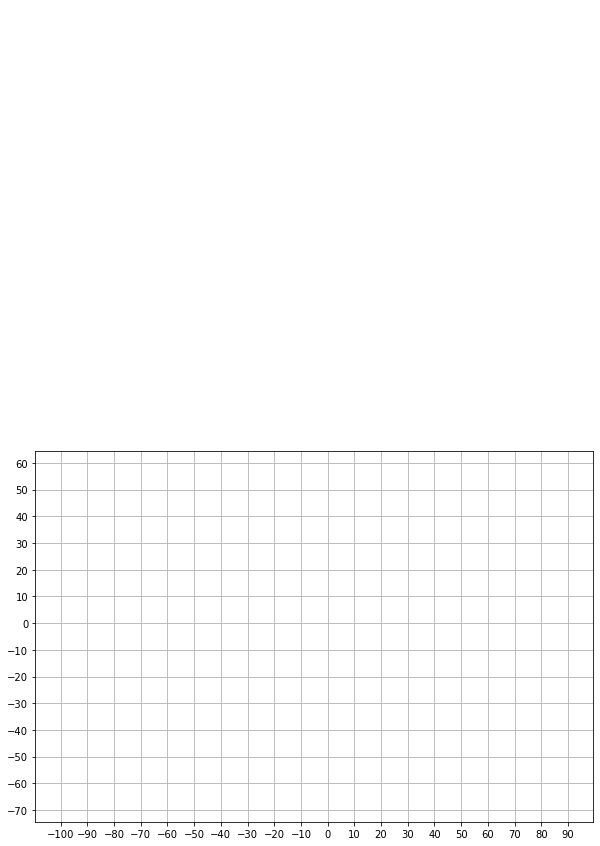

Mean Error Rotation: 6947558.55240
Mean Error Translation: 9718750861.05217
== [Result] Frame: 0, Matches 0, Inliers: 0.00


<Figure size 432x288 with 0 Axes>

Saved at vis_preFeature/frame000.jpg


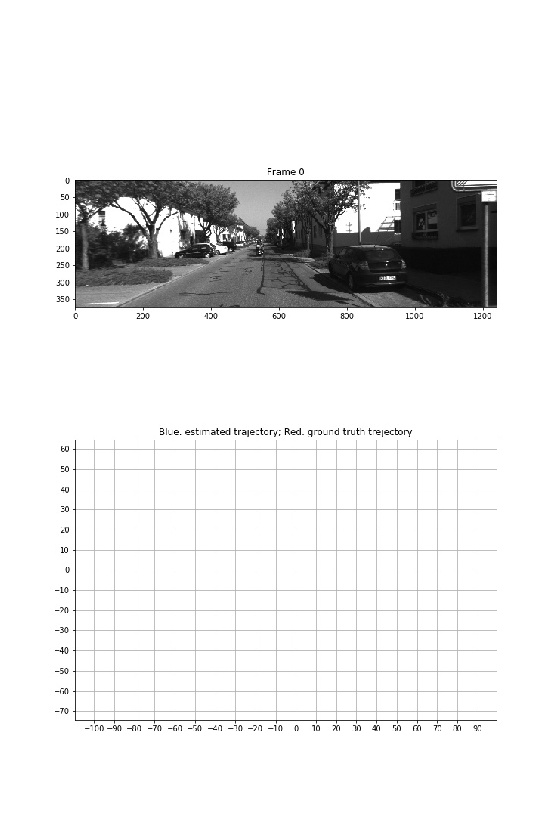

(1463, 4)
[[ 1.     -0.0027 -0.0036  0.0002]
 [ 0.0027  1.     -0.0018 -0.007 ]
 [ 0.0036  0.0018  1.      0.4836]
 [ 0.      0.      0.      1.    ]]
Mean Error Rotation: 0.07455
Mean Error Translation: 97.56619
== [Result] Frame: 1, Matches 1463, Inliers: 99.79


<Figure size 432x288 with 0 Axes>

Saved at vis_preFeature/frame001.jpg
(1463, 4)
[[ 1.     -0.0001 -0.0071 -0.0116]
 [ 0.      1.     -0.003  -0.0121]
 [ 0.0071  0.003   1.      0.9611]
 [ 0.      0.      0.      1.    ]]
Mean Error Rotation: 0.03908
Mean Error Translation: 48.97429
== [Result] Frame: 2, Matches 1463, Inliers: 99.59


<Figure size 432x288 with 0 Axes>

Saved at vis_preFeature/frame002.jpg
(1463, 4)
[[ 0.9999 -0.0008 -0.0112 -0.0185]
 [ 0.0008  1.     -0.0038 -0.0191]
 [ 0.0112  0.0038  0.9999  1.4311]
 [ 0.      0.      0.      1.    ]]
Mean Error Rotation: 0.02719
Mean Error Translation: 32.77996
== [Result] Frame: 3, Matches 1463, Inliers: 98.70


<Figure size 432x288 with 0 Axes>

Saved at vis_preFeature/frame003.jpg
(1463, 4)
[[ 0.9999 -0.0014 -0.0169 -0.0217]
 [ 0.0013  1.     -0.0042 -0.0243]
 [ 0.0169  0.0042  0.9998  1.9056]
 [ 0.      0.      0.      1.    ]]
Mean Error Rotation: 0.02177
Mean Error Translation: 24.68156
== [Result] Frame: 4, Matches 1463, Inliers: 98.36


<Figure size 432x288 with 0 Axes>

Saved at vis_preFeature/frame004.jpg
(1463, 4)
[[ 0.9997 -0.0038 -0.0224 -0.0254]
 [ 0.0038  1.     -0.0041 -0.0325]
 [ 0.0224  0.004   0.9997  2.3902]
 [ 0.      0.      0.      1.    ]]
Mean Error Rotation: 0.01875
Mean Error Translation: 19.82068
== [Result] Frame: 5, Matches 1463, Inliers: 97.61


<Figure size 432x288 with 0 Axes>

Saved at vis_preFeature/frame005.jpg
(1463, 4)
[[ 0.9996 -0.0033 -0.0286 -0.0305]
 [ 0.0032  1.     -0.0047 -0.0428]
 [ 0.0286  0.0046  0.9996  2.8824]
 [ 0.      0.      0.      1.    ]]
Mean Error Rotation: 0.01660
Mean Error Translation: 16.57861
== [Result] Frame: 6, Matches 1463, Inliers: 94.05


<Figure size 432x288 with 0 Axes>

Saved at vis_preFeature/frame006.jpg
(1463, 4)
[[ 0.9995 -0.0006 -0.0328 -0.0572]
 [ 0.0004  1.     -0.0048 -0.0506]
 [ 0.0328  0.0048  0.9995  3.3795]
 [ 0.      0.      0.      1.    ]]
Mean Error Rotation: 0.01489
Mean Error Translation: 14.26206
== [Result] Frame: 7, Matches 1463, Inliers: 93.85


<Figure size 432x288 with 0 Axes>

Saved at vis_preFeature/frame007.jpg
(1463, 4)
[[ 0.9993 -0.0005 -0.0372 -0.0776]
 [ 0.0004  1.     -0.0025 -0.0599]
 [ 0.0372  0.0025  0.9993  3.8918]
 [ 0.      0.      0.      1.    ]]
Mean Error Rotation: 0.01378
Mean Error Translation: 12.52268
== [Result] Frame: 8, Matches 1463, Inliers: 92.14


<Figure size 432x288 with 0 Axes>

Saved at vis_preFeature/frame008.jpg
(1463, 4)
[[ 0.9991 -0.0019 -0.0421 -0.0987]
 [ 0.002   1.      0.001  -0.0712]
 [ 0.0421 -0.0011  0.9991  4.4211]
 [ 0.      0.      0.      1.    ]]
Mean Error Rotation: 0.01318
Mean Error Translation: 11.16801
== [Result] Frame: 9, Matches 1463, Inliers: 91.80


<Figure size 432x288 with 0 Axes>

Saved at vis_preFeature/frame009.jpg
(1463, 4)
[[ 0.999   0.0012 -0.0439 -0.1442]
 [-0.0011  1.      0.0037 -0.0741]
 [ 0.0439 -0.0036  0.999   4.9847]
 [ 0.      0.      0.      1.    ]]
Mean Error Rotation: 0.01250
Mean Error Translation: 10.08084
== [Result] Frame: 10, Matches 1463, Inliers: 95.69


<Figure size 432x288 with 0 Axes>

Saved at vis_preFeature/frame010.jpg
(1463, 4)
[[ 0.9989  0.003  -0.0465 -0.1765]
 [-0.0028  1.      0.0034 -0.0792]
 [ 0.0465 -0.0033  0.9989  5.5701]
 [ 0.      0.      0.      1.    ]]
Mean Error Rotation: 0.01158
Mean Error Translation: 9.18925
== [Result] Frame: 11, Matches 1463, Inliers: 95.63


<Figure size 432x288 with 0 Axes>

Saved at vis_preFeature/frame011.jpg
(1463, 4)
[[ 0.9988  0.0012 -0.0488 -0.2054]
 [-0.0011  1.      0.0029 -0.0782]
 [ 0.0488 -0.0029  0.9988  6.1478]
 [ 0.      0.      0.      1.    ]]
Mean Error Rotation: 0.01089
Mean Error Translation: 8.44708
== [Result] Frame: 12, Matches 1463, Inliers: 90.77


<Figure size 432x288 with 0 Axes>

Saved at vis_preFeature/frame012.jpg
(1463, 4)
[[ 0.9988  0.0013 -0.049  -0.2509]
 [-0.0012  1.      0.0024 -0.0807]
 [ 0.049  -0.0023  0.9988  6.7269]
 [ 0.      0.      0.      1.    ]]
Mean Error Rotation: 0.01027
Mean Error Translation: 7.81889
== [Result] Frame: 13, Matches 1463, Inliers: 91.59


<Figure size 432x288 with 0 Axes>

Saved at vis_preFeature/frame013.jpg
(1463, 4)
[[ 0.9987  0.0015 -0.0506 -0.285 ]
 [-0.0013  1.      0.0035 -0.0851]
 [ 0.0506 -0.0034  0.9987  7.317 ]
 [ 0.      0.      0.      1.    ]]
Mean Error Rotation: 0.00979
Mean Error Translation: 7.27963
== [Result] Frame: 14, Matches 1463, Inliers: 94.53


<Figure size 432x288 with 0 Axes>

Saved at vis_preFeature/frame014.jpg
(1463, 4)
[[ 0.9986 -0.0026 -0.0533 -0.3057]
 [ 0.0027  1.      0.0024 -0.0801]
 [ 0.0533 -0.0025  0.9986  7.9297]
 [ 0.      0.      0.      1.    ]]
Mean Error Rotation: 0.00941
Mean Error Translation: 6.81064
== [Result] Frame: 15, Matches 1463, Inliers: 95.97


<Figure size 432x288 with 0 Axes>

Saved at vis_preFeature/frame015.jpg
(1463, 4)
[[ 0.9985  0.0013 -0.054  -0.3554]
 [-0.0014  1.     -0.0002 -0.0807]
 [ 0.054   0.0003  0.9985  8.5364]
 [ 0.      0.      0.      1.    ]]
Mean Error Rotation: 0.00902
Mean Error Translation: 6.40103
== [Result] Frame: 16, Matches 1463, Inliers: 98.09


<Figure size 432x288 with 0 Axes>

Saved at vis_preFeature/frame016.jpg
(1463, 4)
[[ 0.9985  0.0031 -0.0539 -0.4071]
 [-0.0032  1.     -0.0032 -0.0816]
 [ 0.0539  0.0034  0.9985  9.1569]
 [ 0.      0.      0.      1.    ]]
Mean Error Rotation: 0.00866
Mean Error Translation: 6.03920
== [Result] Frame: 17, Matches 1463, Inliers: 99.32


<Figure size 432x288 with 0 Axes>

Saved at vis_preFeature/frame017.jpg
(1463, 4)
[[ 0.9985  0.0112 -0.0535 -0.4715]
 [-0.0115  0.9999 -0.0052 -0.0859]
 [ 0.0534  0.0058  0.9986  9.7877]
 [ 0.      0.      0.      1.    ]]
Mean Error Rotation: 0.00859
Mean Error Translation: 5.71759
== [Result] Frame: 18, Matches 1463, Inliers: 98.09


<Figure size 432x288 with 0 Axes>

Saved at vis_preFeature/frame018.jpg
(1463, 4)
[[ 0.9985  0.0141 -0.0538 -0.5211]
 [-0.0143  0.9999 -0.0045 -0.0979]
 [ 0.0537  0.0053  0.9985 10.436 ]
 [ 0.      0.      0.      1.    ]]
Mean Error Rotation: 0.00828
Mean Error Translation: 5.42942
== [Result] Frame: 19, Matches 1463, Inliers: 90.57


<Figure size 432x288 with 0 Axes>

Saved at vis_preFeature/frame019.jpg
(1463, 4)
[[ 0.9984  0.013  -0.0549 -0.5644]
 [-0.0132  0.9999 -0.0028 -0.1088]
 [ 0.0548  0.0035  0.9985 11.1083]
 [ 0.      0.      0.      1.    ]]
Mean Error Rotation: 0.00794
Mean Error Translation: 5.16937
== [Result] Frame: 20, Matches 1463, Inliers: 92.69


<Figure size 432x288 with 0 Axes>

Saved at vis_preFeature/frame020.jpg
(1463, 4)
[[ 0.9983  0.0136 -0.056  -0.6086]
 [-0.0137  0.9999 -0.0009 -0.12  ]
 [ 0.056   0.0017  0.9984 11.7755]
 [ 0.      0.      0.      1.    ]]
Mean Error Rotation: 0.00760
Mean Error Translation: 4.93454
== [Result] Frame: 21, Matches 1463, Inliers: 93.92


<Figure size 432x288 with 0 Axes>

Saved at vis_preFeature/frame021.jpg
(1463, 4)
[[ 0.9983  0.0117 -0.0573 -0.6442]
 [-0.0117  0.9999 -0.0006 -0.1299]
 [ 0.0573  0.0012  0.9984 12.4216]
 [ 0.      0.      0.      1.    ]]
Mean Error Rotation: 0.00735
Mean Error Translation: 4.72234
== [Result] Frame: 22, Matches 1463, Inliers: 95.42


<Figure size 432x288 with 0 Axes>

Saved at vis_preFeature/frame022.jpg
(1463, 4)
[[ 0.9982  0.0126 -0.0585 -0.687 ]
 [-0.0127  0.9999 -0.0013 -0.1363]
 [ 0.0585  0.002   0.9983 13.065 ]
 [ 0.      0.      0.      1.    ]]
Mean Error Rotation: 0.00709
Mean Error Translation: 4.52880
== [Result] Frame: 23, Matches 1463, Inliers: 93.30


<Figure size 432x288 with 0 Axes>

Saved at vis_preFeature/frame023.jpg
(1463, 4)
[[ 0.9982  0.0107 -0.0596 -0.7274]
 [-0.0108  0.9999 -0.0019 -0.1452]
 [ 0.0595  0.0025  0.9982 13.7152]
 [ 0.      0.      0.      1.    ]]
Mean Error Rotation: 0.00684
Mean Error Translation: 4.35124
== [Result] Frame: 24, Matches 1463, Inliers: 93.44


<Figure size 432x288 with 0 Axes>

Saved at vis_preFeature/frame024.jpg
(1463, 4)
[[ 0.9981  0.0112 -0.06   -0.7692]
 [-0.0112  0.9999  0.0001 -0.1539]
 [ 0.06    0.0006  0.9982 14.3515]
 [ 0.      0.      0.      1.    ]]
Mean Error Rotation: 0.00661
Mean Error Translation: 4.18885
== [Result] Frame: 25, Matches 1463, Inliers: 96.51


<Figure size 432x288 with 0 Axes>

Saved at vis_preFeature/frame025.jpg
(1463, 4)
[[ 0.9982  0.0148 -0.058  -0.831 ]
 [-0.0146  0.9999  0.0033 -0.1577]
 [ 0.058  -0.0024  0.9983 14.9973]
 [ 0.      0.      0.      1.    ]]
Mean Error Rotation: 0.00651
Mean Error Translation: 4.03887
== [Result] Frame: 26, Matches 1463, Inliers: 97.47


<Figure size 432x288 with 0 Axes>

Saved at vis_preFeature/frame026.jpg
(1463, 4)
[[ 0.9983  0.0188 -0.0553 -0.8921]
 [-0.0184  0.9998  0.0074 -0.1668]
 [ 0.0554 -0.0063  0.9984 15.6506]
 [ 0.      0.      0.      1.    ]]
Mean Error Rotation: 0.00647
Mean Error Translation: 3.89977
== [Result] Frame: 27, Matches 1463, Inliers: 95.49


<Figure size 432x288 with 0 Axes>

Saved at vis_preFeature/frame027.jpg
(1463, 4)
[[ 0.9984  0.0206 -0.0522 -0.946 ]
 [-0.0201  0.9998  0.0097 -0.1638]
 [ 0.0524 -0.0086  0.9986 16.32  ]
 [ 0.      0.      0.      1.    ]]
Mean Error Rotation: 0.00639
Mean Error Translation: 3.77030
== [Result] Frame: 28, Matches 1463, Inliers: 94.60


<Figure size 432x288 with 0 Axes>

Saved at vis_preFeature/frame028.jpg
(1463, 4)
[[ 0.9985  0.0203 -0.0504 -0.9852]
 [-0.0198  0.9998  0.01   -0.162 ]
 [ 0.0506 -0.009   0.9987 17.0058]
 [ 0.      0.      0.      1.    ]]
Mean Error Rotation: 0.00621
Mean Error Translation: 3.64929
== [Result] Frame: 29, Matches 1463, Inliers: 96.86


<Figure size 432x288 with 0 Axes>

Saved at vis_preFeature/frame029.jpg
(1463, 4)
[[ 0.9986  0.0206 -0.0491 -1.0216]
 [-0.0202  0.9998  0.0072 -0.1653]
 [ 0.0492 -0.0062  0.9988 17.6944]
 [ 0.      0.      0.      1.    ]]
Mean Error Rotation: 0.00602
Mean Error Translation: 3.53632
== [Result] Frame: 30, Matches 1463, Inliers: 98.22


<Figure size 432x288 with 0 Axes>

Saved at vis_preFeature/frame030.jpg
(1463, 4)
[[ 0.9986  0.0241 -0.0475 -1.0666]
 [-0.024   0.9997  0.0027 -0.1713]
 [ 0.0476 -0.0016  0.9989 18.3858]
 [ 0.      0.      0.      1.    ]]
Mean Error Rotation: 0.00595
Mean Error Translation: 3.43067
== [Result] Frame: 31, Matches 1463, Inliers: 97.40


<Figure size 432x288 with 0 Axes>

Saved at vis_preFeature/frame031.jpg
(1463, 4)
[[ 0.9987  0.0238 -0.0462 -1.1034]
 [-0.0238  0.9997 -0.0002 -0.1755]
 [ 0.0462  0.0013  0.9989 19.0977]
 [ 0.      0.      0.      1.    ]]
Mean Error Rotation: 0.00580
Mean Error Translation: 3.33121
== [Result] Frame: 32, Matches 1463, Inliers: 96.86


<Figure size 432x288 with 0 Axes>

Saved at vis_preFeature/frame032.jpg
(1463, 4)
[[ 0.9987  0.0219 -0.0451 -1.141 ]
 [-0.0219  0.9998  0.0015 -0.188 ]
 [ 0.0451 -0.0005  0.999  19.8133]
 [ 0.      0.      0.      1.    ]]
Mean Error Rotation: 0.00566
Mean Error Translation: 3.23794
== [Result] Frame: 33, Matches 1463, Inliers: 96.72


<Figure size 432x288 with 0 Axes>

Saved at vis_preFeature/frame033.jpg
(1463, 4)
[[ 0.9988  0.0222 -0.044  -1.1901]
 [-0.0219  0.9997  0.0076 -0.2042]
 [ 0.0442 -0.0066  0.999  20.5305]
 [ 0.      0.      0.      1.    ]]
Mean Error Rotation: 0.00560
Mean Error Translation: 3.15032
== [Result] Frame: 34, Matches 1463, Inliers: 92.48


<Figure size 432x288 with 0 Axes>

Saved at vis_preFeature/frame034.jpg
(1463, 4)
[[ 0.9988  0.0188 -0.0456 -1.2101]
 [-0.0183  0.9998  0.0121 -0.2164]
 [ 0.0458 -0.0112  0.9989 21.2553]
 [ 0.      0.      0.      1.    ]]
Mean Error Rotation: 0.00547
Mean Error Translation: 3.06763
== [Result] Frame: 35, Matches 1463, Inliers: 90.64


<Figure size 432x288 with 0 Axes>

Saved at vis_preFeature/frame035.jpg
(1463, 4)
[[ 0.9988  0.0141 -0.0459 -1.2467]
 [-0.0136  0.9998  0.0121 -0.223 ]
 [ 0.046  -0.0114  0.9989 21.9836]
 [ 0.      0.      0.      1.    ]]
Mean Error Rotation: 0.00545
Mean Error Translation: 2.98942
== [Result] Frame: 36, Matches 1463, Inliers: 85.92


<Figure size 432x288 with 0 Axes>

Saved at vis_preFeature/frame036.jpg
(1463, 4)
[[ 0.9988  0.0158 -0.0453 -1.2972]
 [-0.0154  0.9998  0.0084 -0.2235]
 [ 0.0455 -0.0077  0.9989 22.6795]
 [ 0.      0.      0.      1.    ]]
Mean Error Rotation: 0.00550
Mean Error Translation: 2.91630
== [Result] Frame: 37, Matches 1463, Inliers: 91.39


<Figure size 432x288 with 0 Axes>

Saved at vis_preFeature/frame037.jpg
(1463, 4)
[[ 0.9988  0.0169 -0.0469 -1.3323]
 [-0.0167  0.9998  0.0045 -0.224 ]
 [ 0.047  -0.0037  0.9989 23.3875]
 [ 0.      0.      0.      1.    ]]
Mean Error Rotation: 0.00538
Mean Error Translation: 2.84687
== [Result] Frame: 38, Matches 1463, Inliers: 93.57


<Figure size 432x288 with 0 Axes>

Saved at vis_preFeature/frame038.jpg
(1463, 4)
[[ 0.9986  0.0175 -0.049  -1.4091]
 [-0.0173  0.9998  0.004  -0.2273]
 [ 0.049  -0.0031  0.9988 24.8124]
 [ 0.      0.      0.      1.    ]]
Mean Error Rotation: 0.00526
Mean Error Translation: 2.78455
== [Result] Frame: 39, Matches 1463, Inliers: 91.93


<Figure size 432x288 with 0 Axes>

Saved at vis_preFeature/frame039.jpg
(1463, 4)
[[ 0.9986  0.0136 -0.051  -1.4797]
 [-0.0134  0.9999  0.0048 -0.223 ]
 [ 0.0511 -0.0042  0.9987 26.743 ]
 [ 0.      0.      0.      1.    ]]
Mean Error Rotation: 0.00528
Mean Error Translation: 2.73686
== [Result] Frame: 40, Matches 1463, Inliers: 90.50


<Figure size 432x288 with 0 Axes>

Saved at vis_preFeature/frame040.jpg
(1463, 4)
[[ 0.9985  0.0152 -0.0522 -1.6046]
 [-0.0148  0.9999  0.0076 -0.2388]
 [ 0.0523 -0.0068  0.9986 28.9205]
 [ 0.      0.      0.      1.    ]]
Mean Error Rotation: 0.00521
Mean Error Translation: 2.69788
== [Result] Frame: 41, Matches 1463, Inliers: 87.97


<Figure size 432x288 with 0 Axes>

Saved at vis_preFeature/frame041.jpg
(1463, 4)
[[ 0.9985  0.0158 -0.0527 -1.6509]
 [-0.0154  0.9998  0.0079 -0.2345]
 [ 0.0528 -0.0071  0.9986 29.5563]
 [ 0.      0.      0.      1.    ]]
Mean Error Rotation: 0.00512
Mean Error Translation: 2.64345
== [Result] Frame: 42, Matches 1463, Inliers: 86.88


<Figure size 432x288 with 0 Axes>

Saved at vis_preFeature/frame042.jpg
(1463, 4)
[[ 0.9984  0.0164 -0.0534 -1.6902]
 [-0.0159  0.9998  0.0096 -0.2327]
 [ 0.0536 -0.0088  0.9985 30.2109]
 [ 0.      0.      0.      1.    ]]
Mean Error Rotation: 0.00503
Mean Error Translation: 2.59084
== [Result] Frame: 43, Matches 1463, Inliers: 80.38


<Figure size 432x288 with 0 Axes>

Saved at vis_preFeature/frame043.jpg
(1463, 4)
[[ 0.9984  0.0146 -0.0545 -1.7159]
 [-0.014   0.9998  0.0129 -0.237 ]
 [ 0.0546 -0.0121  0.9984 30.8579]
 [ 0.      0.      0.      1.    ]]
Mean Error Rotation: 0.00497
Mean Error Translation: 2.54087
== [Result] Frame: 44, Matches 1463, Inliers: 84.89


<Figure size 432x288 with 0 Axes>

Saved at vis_preFeature/frame044.jpg
(1463, 4)
[[ 0.9983  0.0215 -0.0548 -1.7649]
 [-0.0207  0.9997  0.0152 -0.2376]
 [ 0.0551 -0.0141  0.9984 31.5274]
 [ 0.      0.      0.      1.    ]]
Mean Error Rotation: 0.00489
Mean Error Translation: 2.49230
== [Result] Frame: 45, Matches 1463, Inliers: 89.13


<Figure size 432x288 with 0 Axes>

Saved at vis_preFeature/frame045.jpg
(1463, 4)
[[ 0.9983  0.0208 -0.0548 -1.8124]
 [-0.0201  0.9997  0.0135 -0.2257]
 [ 0.0551 -0.0124  0.9984 32.2355]
 [ 0.      0.      0.      1.    ]]
Mean Error Rotation: 0.00486
Mean Error Translation: 2.44503
== [Result] Frame: 46, Matches 1463, Inliers: 93.98


<Figure size 432x288 with 0 Axes>

Saved at vis_preFeature/frame046.jpg
(1463, 4)
[[ 0.9983  0.0208 -0.0549 -1.8568]
 [-0.0203  0.9997  0.0114 -0.2212]
 [ 0.0551 -0.0103  0.9984 32.9556]
 [ 0.      0.      0.      1.    ]]
Mean Error Rotation: 0.00477
Mean Error Translation: 2.39923
== [Result] Frame: 47, Matches 1463, Inliers: 94.87


<Figure size 432x288 with 0 Axes>

Saved at vis_preFeature/frame047.jpg
(1463, 4)
[[ 0.9982  0.0291 -0.0531 -1.9279]
 [-0.0287  0.9995  0.0093 -0.2265]
 [ 0.0533 -0.0078  0.9985 33.6726]
 [ 0.      0.      0.      1.    ]]
Mean Error Rotation: 0.00485
Mean Error Translation: 2.35528
== [Result] Frame: 48, Matches 1463, Inliers: 92.28


<Figure size 432x288 with 0 Axes>

Saved at vis_preFeature/frame048.jpg
(1463, 4)
[[ 0.9981  0.0336 -0.0522 -1.9937]
 [-0.0332  0.9994  0.0095 -0.2322]
 [ 0.0525 -0.0077  0.9986 34.3999]
 [ 0.      0.      0.      1.    ]]
Mean Error Rotation: 0.00490
Mean Error Translation: 2.31283
== [Result] Frame: 49, Matches 1463, Inliers: 88.45


<Figure size 432x288 with 0 Axes>

Saved at vis_preFeature/frame049.jpg
(1463, 4)
[[ 0.9981  0.0324 -0.0533 -2.0388]
 [-0.0319  0.9994  0.0109 -0.2361]
 [ 0.0536 -0.0091  0.9985 35.1552]
 [ 0.      0.      0.      1.    ]]
Mean Error Rotation: 0.00483
Mean Error Translation: 2.27150
== [Result] Frame: 50, Matches 1463, Inliers: 87.08


<Figure size 432x288 with 0 Axes>

Saved at vis_preFeature/frame050.jpg


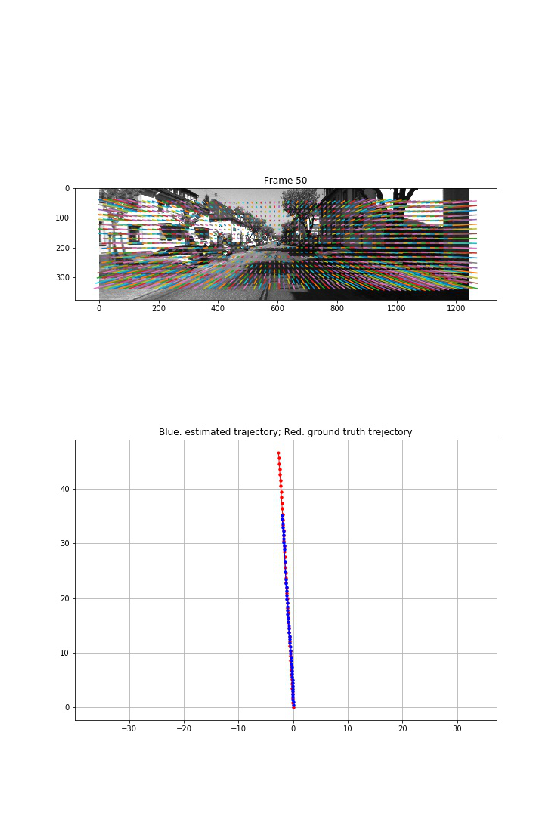

(1463, 4)
[[ 0.9979  0.0367 -0.0527 -2.1043]
 [-0.0361  0.9993  0.0126 -0.2482]
 [ 0.0531 -0.0107  0.9985 35.934 ]
 [ 0.      0.      0.      1.    ]]
Mean Error Rotation: 0.00485
Mean Error Translation: 2.23122
== [Result] Frame: 51, Matches 1463, Inliers: 87.01


<Figure size 432x288 with 0 Axes>

Saved at vis_preFeature/frame051.jpg
(1463, 4)
[[ 0.9978  0.0404 -0.052  -2.1657]
 [-0.04    0.9992  0.0092 -0.2534]
 [ 0.0523 -0.0071  0.9986 36.7306]
 [ 0.      0.      0.      1.    ]]
Mean Error Rotation: 0.00481
Mean Error Translation: 2.19200
== [Result] Frame: 52, Matches 1463, Inliers: 87.01


<Figure size 432x288 with 0 Axes>

Saved at vis_preFeature/frame052.jpg
(1463, 4)
[[ 0.9977  0.0403 -0.0537 -2.2125]
 [-0.04    0.9992  0.0059 -0.2677]
 [ 0.0539 -0.0037  0.9985 37.6222]
 [ 0.      0.      0.      1.    ]]
Mean Error Rotation: 0.00478
Mean Error Translation: 2.15236
== [Result] Frame: 53, Matches 1463, Inliers: 90.29


<Figure size 432x288 with 0 Axes>

Saved at vis_preFeature/frame053.jpg
(1463, 4)
[[ 0.9977  0.0408 -0.0545 -2.2695]
 [-0.0406  0.9992  0.0046 -0.2722]
 [ 0.0547 -0.0024  0.9985 38.5777]
 [ 0.      0.      0.      1.    ]]
Mean Error Rotation: 0.00471
Mean Error Translation: 2.11322
== [Result] Frame: 54, Matches 1463, Inliers: 95.35


<Figure size 432x288 with 0 Axes>

Saved at vis_preFeature/frame054.jpg
(1463, 4)
[[ 0.9977  0.0383 -0.0552 -2.3172]
 [-0.0379  0.9992  0.0082 -0.2792]
 [ 0.0555 -0.0061  0.9984 39.5677]
 [ 0.      0.      0.      1.    ]]
Mean Error Rotation: 0.00468
Mean Error Translation: 2.07546
== [Result] Frame: 55, Matches 1463, Inliers: 97.20


<Figure size 432x288 with 0 Axes>

Saved at vis_preFeature/frame055.jpg
(1463, 4)
[[ 0.9977  0.0387 -0.0551 -2.3869]
 [-0.0381  0.9992  0.012  -0.2963]
 [ 0.0556 -0.0099  0.9984 40.66  ]
 [ 0.      0.      0.      1.    ]]
Mean Error Rotation: 0.00468
Mean Error Translation: 2.04048
== [Result] Frame: 56, Matches 1463, Inliers: 93.85


<Figure size 432x288 with 0 Axes>

Saved at vis_preFeature/frame056.jpg
(1463, 4)
[[ 0.9978  0.0354 -0.0565 -2.4323]
 [-0.0347  0.9993  0.0128 -0.3035]
 [ 0.057  -0.0108  0.9983 41.8138]
 [ 0.      0.      0.      1.    ]]
Mean Error Rotation: 0.00465
Mean Error Translation: 2.00795
== [Result] Frame: 57, Matches 1463, Inliers: 96.04


<Figure size 432x288 with 0 Axes>

Saved at vis_preFeature/frame057.jpg
(1463, 4)
[[ 0.9978  0.0329 -0.0574 -2.4677]
 [-0.0322  0.9994  0.0121 -0.3087]
 [ 0.0578 -0.0102  0.9983 42.4965]
 [ 0.      0.      0.      1.    ]]
Mean Error Rotation: 0.00459
Mean Error Translation: 1.97820
== [Result] Frame: 58, Matches 1463, Inliers: 98.77


<Figure size 432x288 with 0 Axes>

Saved at vis_preFeature/frame058.jpg
(1463, 4)
[[ 0.9978  0.0309 -0.0584 -2.5033]
 [-0.0303  0.9995  0.0112 -0.3133]
 [ 0.0587 -0.0094  0.9982 43.1616]
 [ 0.      0.      0.      1.    ]]
Mean Error Rotation: 0.00456
Mean Error Translation: 1.94977
== [Result] Frame: 59, Matches 1463, Inliers: 96.17


<Figure size 432x288 with 0 Axes>

Saved at vis_preFeature/frame059.jpg
(1463, 4)
[[ 0.9977  0.0304 -0.0598 -2.5417]
 [-0.0297  0.9995  0.0126 -0.3154]
 [ 0.0601 -0.0108  0.9981 43.8303]
 [ 0.      0.      0.      1.    ]]
Mean Error Rotation: 0.00451
Mean Error Translation: 1.92214
== [Result] Frame: 60, Matches 1463, Inliers: 94.46


<Figure size 432x288 with 0 Axes>

Saved at vis_preFeature/frame060.jpg
(1463, 4)
[[ 0.9978  0.0292 -0.0599 -2.5913]
 [-0.0282  0.9995  0.0166 -0.3134]
 [ 0.0604 -0.0149  0.9981 44.5113]
 [ 0.      0.      0.      1.    ]]
Mean Error Rotation: 0.00448
Mean Error Translation: 1.89526
== [Result] Frame: 61, Matches 1463, Inliers: 93.57


<Figure size 432x288 with 0 Axes>

Saved at vis_preFeature/frame061.jpg
(1463, 4)
[[ 0.9977  0.0339 -0.058  -2.6598]
 [-0.0327  0.9992  0.0215 -0.3115]
 [ 0.0587 -0.0196  0.9981 45.2124]
 [ 0.      0.      0.      1.    ]]
Mean Error Rotation: 0.00456
Mean Error Translation: 1.86890
== [Result] Frame: 62, Matches 1463, Inliers: 94.60


<Figure size 432x288 with 0 Axes>

Saved at vis_preFeature/frame062.jpg
(1463, 4)
[[ 0.9976  0.0378 -0.0586 -2.7098]
 [-0.0364  0.999   0.0242 -0.3118]
 [ 0.0595 -0.022   0.998  45.949 ]
 [ 0.      0.      0.      1.    ]]
Mean Error Rotation: 0.00454
Mean Error Translation: 1.84268
== [Result] Frame: 63, Matches 1463, Inliers: 98.22


<Figure size 432x288 with 0 Axes>

Saved at vis_preFeature/frame063.jpg
(1463, 4)
[[ 0.9974  0.0406 -0.0598 -2.763 ]
 [-0.0395  0.999   0.0207 -0.3122]
 [ 0.0605 -0.0183  0.998  46.6535]
 [ 0.      0.      0.      1.    ]]
Mean Error Rotation: 0.00451
Mean Error Translation: 1.81760
== [Result] Frame: 64, Matches 1463, Inliers: 98.70


<Figure size 432x288 with 0 Axes>

Saved at vis_preFeature/frame064.jpg
(1463, 4)
[[ 0.9972  0.0403 -0.0633 -2.7926]
 [-0.0395  0.9991  0.0141 -0.32  ]
 [ 0.0638 -0.0116  0.9979 47.317 ]
 [ 0.      0.      0.      1.    ]]
Mean Error Rotation: 0.00450
Mean Error Translation: 1.79370
== [Result] Frame: 65, Matches 1463, Inliers: 96.79


<Figure size 432x288 with 0 Axes>

Saved at vis_preFeature/frame065.jpg
(1463, 4)
[[ 0.997   0.0453 -0.0632 -2.853 ]
 [-0.0447  0.999   0.0096 -0.3199]
 [ 0.0636 -0.0068  0.998  47.9855]
 [ 0.      0.      0.      1.    ]]
Mean Error Rotation: 0.00453
Mean Error Translation: 1.77028
== [Result] Frame: 66, Matches 1463, Inliers: 97.40


<Figure size 432x288 with 0 Axes>

Saved at vis_preFeature/frame066.jpg
(1463, 4)
[[ 0.9966  0.0532 -0.0633 -2.9146]
 [-0.0526  0.9986  0.0105 -0.3192]
 [ 0.0638 -0.0072  0.9979 48.6619]
 [ 0.      0.      0.      1.    ]]
Mean Error Rotation: 0.00453
Mean Error Translation: 1.74739
== [Result] Frame: 67, Matches 1463, Inliers: 95.56


<Figure size 432x288 with 0 Axes>

Saved at vis_preFeature/frame067.jpg
(1463, 4)
[[ 0.9963  0.0575 -0.0639 -2.968 ]
 [-0.0568  0.9983  0.0129 -0.3216]
 [ 0.0645 -0.0093  0.9979 49.3463]
 [ 0.      0.      0.      1.    ]]
Mean Error Rotation: 0.00449
Mean Error Translation: 1.72488
== [Result] Frame: 68, Matches 1463, Inliers: 93.64


<Figure size 432x288 with 0 Axes>

Saved at vis_preFeature/frame068.jpg
(1463, 4)
[[ 0.9961  0.0591 -0.0658 -3.0084]
 [-0.0583  0.9982  0.0143 -0.3221]
 [ 0.0665 -0.0104  0.9977 50.0029]
 [ 0.      0.      0.      1.    ]]
Mean Error Rotation: 0.00445
Mean Error Translation: 1.70322
== [Result] Frame: 69, Matches 1463, Inliers: 96.38


<Figure size 432x288 with 0 Axes>

Saved at vis_preFeature/frame069.jpg
(1463, 4)
[[ 0.996   0.061  -0.0658 -3.0662]
 [-0.0602  0.9981  0.0143 -0.3229]
 [ 0.0666 -0.0102  0.9977 50.6287]
 [ 0.      0.      0.      1.    ]]
Mean Error Rotation: 0.00443
Mean Error Translation: 1.68238
== [Result] Frame: 70, Matches 1463, Inliers: 93.85


<Figure size 432x288 with 0 Axes>

Saved at vis_preFeature/frame070.jpg
(1463, 4)
[[ 0.9957  0.0653 -0.0659 -3.1309]
 [-0.0644  0.9978  0.0154 -0.3253]
 [ 0.0668 -0.011   0.9977 51.2564]
 [ 0.      0.      0.      1.    ]]
Mean Error Rotation: 0.00443
Mean Error Translation: 1.66190
== [Result] Frame: 71, Matches 1463, Inliers: 93.92


<Figure size 432x288 with 0 Axes>

Saved at vis_preFeature/frame071.jpg
(1463, 4)
[[ 0.9957  0.0643 -0.0671 -3.1778]
 [-0.0634  0.9979  0.0155 -0.3202]
 [ 0.0679 -0.0112  0.9976 51.9102]
 [ 0.      0.      0.      1.    ]]
Mean Error Rotation: 0.00442
Mean Error Translation: 1.64151
== [Result] Frame: 72, Matches 1463, Inliers: 90.91


<Figure size 432x288 with 0 Axes>

Saved at vis_preFeature/frame072.jpg
(1463, 4)
[[ 0.9957  0.0625 -0.0683 -3.2202]
 [-0.0616  0.998   0.0159 -0.321 ]
 [ 0.0692 -0.0116  0.9975 52.5572]
 [ 0.      0.      0.      1.    ]]
Mean Error Rotation: 0.00439
Mean Error Translation: 1.62156
== [Result] Frame: 73, Matches 1463, Inliers: 93.92


<Figure size 432x288 with 0 Axes>

Saved at vis_preFeature/frame073.jpg
(1463, 4)
[[ 0.9956  0.062  -0.0698 -3.2743]
 [-0.0609  0.998   0.0174 -0.3252]
 [ 0.0708 -0.0131  0.9974 53.383 ]
 [ 0.      0.      0.      1.    ]]
Mean Error Rotation: 0.00435
Mean Error Translation: 1.59998
== [Result] Frame: 74, Matches 1463, Inliers: 91.80


<Figure size 432x288 with 0 Axes>

Saved at vis_preFeature/frame074.jpg
(1463, 4)
[[ 0.9952  0.0688 -0.0698 -3.3428]
 [-0.0675  0.9975  0.021  -0.3342]
 [ 0.071  -0.0162  0.9973 54.0386]
 [ 0.      0.      0.      1.    ]]
Mean Error Rotation: 0.00438
Mean Error Translation: 1.58065
== [Result] Frame: 75, Matches 1463, Inliers: 95.01


<Figure size 432x288 with 0 Axes>

Saved at vis_preFeature/frame075.jpg
(1463, 4)
[[ 0.9951  0.0682 -0.072  -3.378 ]
 [-0.0665  0.9974  0.026  -0.3413]
 [ 0.0736 -0.0211  0.9971 54.6855]
 [ 0.      0.      0.      1.    ]]
Mean Error Rotation: 0.00437
Mean Error Translation: 1.56184
== [Result] Frame: 76, Matches 1463, Inliers: 94.33


<Figure size 432x288 with 0 Axes>

Saved at vis_preFeature/frame076.jpg
(1463, 4)
[[ 0.9948  0.0709 -0.0736 -3.431 ]
 [-0.069   0.9972  0.0281 -0.3399]
 [ 0.0753 -0.0228  0.9969 55.3733]
 [ 0.      0.      0.      1.    ]]
Mean Error Rotation: 0.00432
Mean Error Translation: 1.54277
== [Result] Frame: 77, Matches 1463, Inliers: 98.09


<Figure size 432x288 with 0 Axes>

Saved at vis_preFeature/frame077.jpg
(1463, 4)
[[ 0.9945  0.0717 -0.0761 -3.4748]
 [-0.07    0.9973  0.0241 -0.3367]
 [ 0.0776 -0.0187  0.9968 56.0415]
 [ 0.      0.      0.      1.    ]]
Mean Error Rotation: 0.00431
Mean Error Translation: 1.52419
== [Result] Frame: 78, Matches 1463, Inliers: 98.02


<Figure size 432x288 with 0 Axes>

Saved at vis_preFeature/frame078.jpg
(1463, 4)
[[ 0.9944  0.0693 -0.0792 -3.5128]
 [-0.0682  0.9975  0.017  -0.3342]
 [ 0.0802 -0.0115  0.9967 56.6987]
 [ 0.      0.      0.      1.    ]]
Mean Error Rotation: 0.00432
Mean Error Translation: 1.50596
== [Result] Frame: 79, Matches 1463, Inliers: 94.53


<Figure size 432x288 with 0 Axes>

Saved at vis_preFeature/frame079.jpg
(1463, 4)
[[ 0.9944  0.0666 -0.0822 -3.5496]
 [-0.0659  0.9978  0.011  -0.3289]
 [ 0.0827 -0.0056  0.9966 57.2921]
 [ 0.      0.      0.      1.    ]]
Mean Error Rotation: 0.00429
Mean Error Translation: 1.48870
== [Result] Frame: 80, Matches 1463, Inliers: 96.38


<Figure size 432x288 with 0 Axes>

Saved at vis_preFeature/frame080.jpg
(1463, 4)
[[ 0.9942  0.0674 -0.0832 -3.5927]
 [-0.0668  0.9977  0.01   -0.3266]
 [ 0.0837 -0.0044  0.9965 57.813 ]
 [ 0.      0.      0.      1.    ]]
Mean Error Rotation: 0.00426
Mean Error Translation: 1.47252
== [Result] Frame: 81, Matches 1463, Inliers: 96.38


<Figure size 432x288 with 0 Axes>

Saved at vis_preFeature/frame081.jpg
(1463, 4)
[[ 0.994   0.0712 -0.0833 -3.6443]
 [-0.0704  0.9974  0.0135 -0.3259]
 [ 0.0841 -0.0075  0.9964 58.294 ]
 [ 0.      0.      0.      1.    ]]
Mean Error Rotation: 0.00424
Mean Error Translation: 1.45697
== [Result] Frame: 82, Matches 1463, Inliers: 96.51


<Figure size 432x288 with 0 Axes>

Saved at vis_preFeature/frame082.jpg
(1463, 4)
[[ 0.9939  0.0717 -0.0843 -3.6886]
 [-0.0706  0.9974  0.0154 -0.3245]
 [ 0.0851 -0.0094  0.9963 58.7576]
 [ 0.      0.      0.      1.    ]]
Mean Error Rotation: 0.00421
Mean Error Translation: 1.44179
== [Result] Frame: 83, Matches 1463, Inliers: 97.06


<Figure size 432x288 with 0 Axes>

Saved at vis_preFeature/frame083.jpg
(1463, 4)
[[ 0.9939  0.0715 -0.0839 -3.7417]
 [-0.0708  0.9974  0.0115 -0.32  ]
 [ 0.0845 -0.0055  0.9964 59.1944]
 [ 0.      0.      0.      1.    ]]
Mean Error Rotation: 0.00423
Mean Error Translation: 1.42697
== [Result] Frame: 84, Matches 1463, Inliers: 96.45


<Figure size 432x288 with 0 Axes>

Saved at vis_preFeature/frame084.jpg
(1463, 4)
[[ 0.9943  0.0659 -0.0836 -3.7773]
 [-0.0656  0.9978  0.0062 -0.321 ]
 [ 0.0838 -0.0006  0.9965 59.6014]
 [ 0.      0.      0.      1.    ]]
Mean Error Rotation: 0.00422
Mean Error Translation: 1.41262
== [Result] Frame: 85, Matches 1463, Inliers: 97.81


<Figure size 432x288 with 0 Axes>

Saved at vis_preFeature/frame085.jpg
(1463, 4)
[[ 0.9946  0.0628 -0.0831 -3.7998]
 [-0.0629  0.998   0.0017 -0.3271]
 [ 0.0831  0.0036  0.9965 59.9749]
 [ 0.      0.      0.      1.    ]]
Mean Error Rotation: 0.00420
Mean Error Translation: 1.39879
== [Result] Frame: 86, Matches 1463, Inliers: 98.36


<Figure size 432x288 with 0 Axes>

Saved at vis_preFeature/frame086.jpg
(1463, 4)
[[ 0.9946  0.0635 -0.0815 -3.8109]
 [-0.0636  0.998   0.0014 -0.3314]
 [ 0.0815  0.0038  0.9967 60.333 ]
 [ 0.      0.      0.      1.    ]]
Mean Error Rotation: 0.00418
Mean Error Translation: 1.38534
== [Result] Frame: 87, Matches 1463, Inliers: 99.73


<Figure size 432x288 with 0 Axes>

Saved at vis_preFeature/frame087.jpg
(1463, 4)
[[ 0.9946  0.0696 -0.077  -3.8465]
 [-0.0695  0.9976  0.0042 -0.3355]
 [ 0.0771  0.0011  0.997  60.6849]
 [ 0.      0.      0.      1.    ]]
Mean Error Rotation: 0.00414
Mean Error Translation: 1.37209
== [Result] Frame: 88, Matches 1463, Inliers: 100.00


<Figure size 432x288 with 0 Axes>

Saved at vis_preFeature/frame088.jpg
(1463, 4)
[[ 0.995   0.0684 -0.0732 -3.8596]
 [-0.0681  0.9977  0.0077 -0.3459]
 [ 0.0736 -0.0027  0.9973 61.0318]
 [ 0.      0.      0.      1.    ]]
Mean Error Rotation: 0.00411
Mean Error Translation: 1.35904
== [Result] Frame: 89, Matches 1463, Inliers: 100.00


<Figure size 432x288 with 0 Axes>

Saved at vis_preFeature/frame089.jpg
(1463, 4)
[[ 0.9955  0.0669 -0.0671 -3.8795]
 [-0.0663  0.9977  0.012  -0.3532]
 [ 0.0677 -0.0075  0.9977 61.3781]
 [ 0.      0.      0.      1.    ]]
Mean Error Rotation: 0.00412
Mean Error Translation: 1.34614
== [Result] Frame: 90, Matches 1463, Inliers: 100.00


<Figure size 432x288 with 0 Axes>

Saved at vis_preFeature/frame090.jpg
(1463, 4)
[[ 0.9962  0.0634 -0.059  -3.8915]
 [-0.0626  0.9979  0.0153 -0.3615]
 [ 0.0598 -0.0115  0.9981 61.7282]
 [ 0.      0.      0.      1.    ]]
Mean Error Rotation: 0.00409
Mean Error Translation: 1.33334
== [Result] Frame: 91, Matches 1463, Inliers: 99.86


<Figure size 432x288 with 0 Axes>

Saved at vis_preFeature/frame091.jpg
(1463, 4)
[[ 0.9965  0.0674 -0.0486 -3.9051]
 [-0.0668  0.9977  0.0148 -0.3657]
 [ 0.0494 -0.0115  0.9987 62.0785]
 [ 0.      0.      0.      1.    ]]
Mean Error Rotation: 0.00406
Mean Error Translation: 1.32062
== [Result] Frame: 92, Matches 1463, Inliers: 100.00


<Figure size 432x288 with 0 Axes>

Saved at vis_preFeature/frame092.jpg
(1463, 4)
[[ 0.9967  0.0731 -0.0341 -3.9113]
 [-0.0727  0.9973  0.0139 -0.3725]
 [ 0.035  -0.0113  0.9993 62.4186]
 [ 0.      0.      0.      1.    ]]
Mean Error Rotation: 0.00403
Mean Error Translation: 1.30817
== [Result] Frame: 93, Matches 1463, Inliers: 100.00


<Figure size 432x288 with 0 Axes>

Saved at vis_preFeature/frame093.jpg
(1463, 4)
[[ 0.9968  0.0779 -0.0167 -3.9068]
 [-0.0777  0.9969  0.0138 -0.3794]
 [ 0.0177 -0.0125  0.9998 62.7526]
 [ 0.      0.      0.      1.    ]]
Mean Error Rotation: 0.00400
Mean Error Translation: 1.29590
== [Result] Frame: 94, Matches 1463, Inliers: 99.66


<Figure size 432x288 with 0 Axes>

Saved at vis_preFeature/frame094.jpg
(1463, 4)
[[ 0.9971  0.0765  0.0041 -3.8823]
 [-0.0765  0.997   0.0139 -0.391 ]
 [-0.003  -0.0141  0.9999 63.0776]
 [ 0.      0.      0.      1.    ]]
Mean Error Rotation: 0.00398
Mean Error Translation: 1.28384
== [Result] Frame: 95, Matches 1463, Inliers: 99.04


<Figure size 432x288 with 0 Axes>

Saved at vis_preFeature/frame095.jpg
(1463, 4)
[[ 0.9968  0.0741  0.0295 -3.8512]
 [-0.0745  0.9971  0.0136 -0.398 ]
 [-0.0284 -0.0157  0.9995 63.4022]
 [ 0.      0.      0.      1.    ]]
Mean Error Rotation: 0.00396
Mean Error Translation: 1.27187
== [Result] Frame: 96, Matches 1463, Inliers: 100.00


<Figure size 432x288 with 0 Axes>

Saved at vis_preFeature/frame096.jpg
(1463, 4)
[[ 0.9957  0.0723  0.0574 -3.8025]
 [-0.0731  0.9972  0.0135 -0.4057]
 [-0.0563 -0.0177  0.9983 63.7234]
 [ 0.      0.      0.      1.    ]]
Mean Error Rotation: 0.00393
Mean Error Translation: 1.26012
== [Result] Frame: 97, Matches 1463, Inliers: 99.38


<Figure size 432x288 with 0 Axes>

Saved at vis_preFeature/frame097.jpg
(1463, 4)
[[ 0.9939  0.0676  0.0866 -3.7204]
 [-0.0689  0.9975  0.0125 -0.4124]
 [-0.0855 -0.0183  0.9962 64.0396]
 [ 0.      0.      0.      1.    ]]
Mean Error Rotation: 0.00397
Mean Error Translation: 1.24861
== [Result] Frame: 98, Matches 1463, Inliers: 99.32


<Figure size 432x288 with 0 Axes>

Saved at vis_preFeature/frame098.jpg
(1463, 4)
[[ 0.9903  0.0665  0.122  -3.6453]
 [-0.0683  0.9976  0.0107 -0.417 ]
 [-0.121  -0.0189  0.9925 64.3582]
 [ 0.      0.      0.      1.    ]]
Mean Error Rotation: 0.00395
Mean Error Translation: 1.23714
== [Result] Frame: 99, Matches 1463, Inliers: 98.70


<Figure size 432x288 with 0 Axes>

Saved at vis_preFeature/frame099.jpg
(1463, 4)
[[ 0.9851  0.0629  0.1601 -3.5414]
 [-0.0649  0.9979  0.0078 -0.4237]
 [-0.1592 -0.0181  0.9871 64.6651]
 [ 0.      0.      0.      1.    ]]
Mean Error Rotation: 0.00397
Mean Error Translation: 1.22599
== [Result] Frame: 100, Matches 1463, Inliers: 98.22


<Figure size 432x288 with 0 Axes>

Saved at vis_preFeature/frame100.jpg


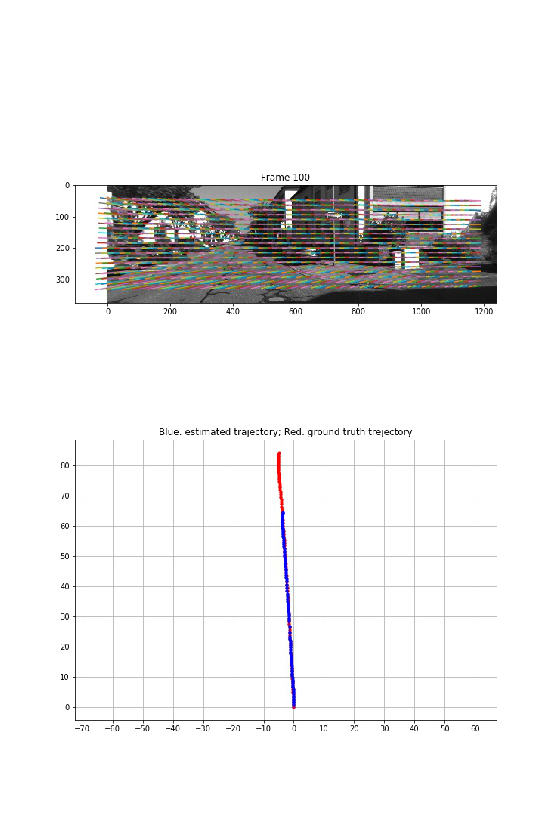

(1463, 4)
[[ 0.9781  0.0564  0.2004 -3.4095]
 [-0.0584  0.9983  0.0042 -0.4307]
 [-0.1998 -0.0158  0.9797 64.964 ]
 [ 0.      0.      0.      1.    ]]
Mean Error Rotation: 0.00404
Mean Error Translation: 1.21501
== [Result] Frame: 101, Matches 1463, Inliers: 98.43


<Figure size 432x288 with 0 Axes>

Saved at vis_preFeature/frame101.jpg
(1463, 4)
[[ 0.9678  0.0537  0.2458 -3.2758]
 [-0.0552  0.9985 -0.0008 -0.442 ]
 [-0.2454 -0.0128  0.9693 65.2551]
 [ 0.      0.      0.      1.    ]]
Mean Error Rotation: 0.00408
Mean Error Translation: 1.20407
== [Result] Frame: 102, Matches 1463, Inliers: 97.61


<Figure size 432x288 with 0 Axes>

Saved at vis_preFeature/frame102.jpg
(1463, 4)
[[ 0.9537  0.0521  0.2962 -3.1362]
 [-0.0525  0.9986 -0.0064 -0.4529]
 [-0.2961 -0.0095  0.9551 65.5364]
 [ 0.      0.      0.      1.    ]]
Mean Error Rotation: 0.00408
Mean Error Translation: 1.19340
== [Result] Frame: 103, Matches 1463, Inliers: 96.79


<Figure size 432x288 with 0 Axes>

Saved at vis_preFeature/frame103.jpg
(1463, 4)
[[ 0.9349  0.0512  0.3513 -2.9949]
 [-0.0504  0.9987 -0.0113 -0.4581]
 [-0.3514 -0.0072  0.9362 65.8135]
 [ 0.      0.      0.      1.    ]]
Mean Error Rotation: 0.00406
Mean Error Translation: 1.18275
== [Result] Frame: 104, Matches 1463, Inliers: 97.61


<Figure size 432x288 with 0 Axes>

Saved at vis_preFeature/frame104.jpg
(1463, 4)
[[ 0.9118  0.0506  0.4076 -2.8356]
 [-0.0484  0.9987 -0.0157 -0.4659]
 [-0.4078 -0.0054  0.913  66.0766]
 [ 0.      0.      0.      1.    ]]
Mean Error Rotation: 0.00403
Mean Error Translation: 1.17240
== [Result] Frame: 105, Matches 1463, Inliers: 97.47


<Figure size 432x288 with 0 Axes>

Saved at vis_preFeature/frame105.jpg
(1463, 4)
[[ 0.8841  0.0489  0.4648 -2.6572]
 [-0.0447  0.9988 -0.0201 -0.4755]
 [-0.4652 -0.003   0.8852 66.3274]
 [ 0.      0.      0.      1.    ]]
Mean Error Rotation: 0.00402
Mean Error Translation: 1.16218
== [Result] Frame: 106, Matches 1463, Inliers: 97.74


<Figure size 432x288 with 0 Axes>

Saved at vis_preFeature/frame106.jpg
(1463, 4)
[[ 0.8539  0.0432  0.5186 -2.4421]
 [-0.0353  0.9991 -0.025  -0.4905]
 [-0.5192  0.0031  0.8547 66.539 ]
 [ 0.      0.      0.      1.    ]]
Mean Error Rotation: 0.00406
Mean Error Translation: 1.15208
== [Result] Frame: 107, Matches 1463, Inliers: 98.29


<Figure size 432x288 with 0 Axes>

Saved at vis_preFeature/frame107.jpg
(1463, 4)
[[ 0.82    0.0397  0.571  -2.2215]
 [-0.0285  0.9992 -0.0284 -0.506 ]
 [-0.5717  0.007   0.8204 66.7456]
 [ 0.      0.      0.      1.    ]]
Mean Error Rotation: 0.00408
Mean Error Translation: 1.14222
== [Result] Frame: 108, Matches 1463, Inliers: 98.91


<Figure size 432x288 with 0 Axes>

Saved at vis_preFeature/frame108.jpg
(1463, 4)
[[ 0.7897  0.0351  0.6125 -1.1401]
 [-0.0136  0.9991 -0.0398 -0.5344]
 [-0.6134  0.0231  0.7895 66.9867]
 [ 0.      0.      0.      1.    ]]
Mean Error Rotation: 0.00431
Mean Error Translation: 1.13912
== [Result] Frame: 109, Matches 1463, Inliers: 99.52


<Figure size 432x288 with 0 Axes>

Saved at vis_preFeature/frame109.jpg
(1463, 4)
[[ 0.7553  0.0317  0.6546 -0.8331]
 [-0.0047  0.9991 -0.0429 -0.5533]
 [-0.6554  0.0293  0.7547 67.0997]
 [ 0.      0.      0.      1.    ]]
Mean Error Rotation: 0.00443
Mean Error Translation: 1.13000
== [Result] Frame: 110, Matches 1463, Inliers: 98.09


<Figure size 432x288 with 0 Axes>

Saved at vis_preFeature/frame110.jpg
(1463, 4)
[[ 0.7181  0.028   0.6954 -0.5196]
 [ 0.0059  0.9989 -0.0463 -0.5645]
 [-0.6959  0.0374  0.7172 67.2202]
 [ 0.      0.      0.      1.    ]]
Mean Error Rotation: 0.00453
Mean Error Translation: 1.12078
== [Result] Frame: 111, Matches 1463, Inliers: 95.83


<Figure size 432x288 with 0 Axes>

Saved at vis_preFeature/frame111.jpg
(1463, 4)
[[ 0.673   0.0269  0.7392 -0.2799]
 [ 0.0109  0.9989 -0.0463 -0.5854]
 [-0.7396  0.0392  0.6719 67.3988]
 [ 0.      0.      0.      1.    ]]
Mean Error Rotation: 0.00452
Mean Error Translation: 1.11155
== [Result] Frame: 112, Matches 1463, Inliers: 98.15


<Figure size 432x288 with 0 Axes>

Saved at vis_preFeature/frame112.jpg
(1463, 4)
[[ 0.629   0.0246  0.777  -0.0167]
 [ 0.0184  0.9987 -0.0465 -0.6011]
 [-0.7772  0.0435  0.6278 67.5488]
 [ 0.      0.      0.      1.    ]]
Mean Error Rotation: 0.00450
Mean Error Translation: 1.10240
== [Result] Frame: 113, Matches 1463, Inliers: 98.70


<Figure size 432x288 with 0 Axes>

Saved at vis_preFeature/frame113.jpg
(1463, 4)
[[ 0.5855  0.0264  0.8102  0.4176]
 [ 0.02    0.9987 -0.047  -0.6259]
 [-0.8104  0.0437  0.5842 67.7638]
 [ 0.      0.      0.      1.    ]]
Mean Error Rotation: 0.00447
Mean Error Translation: 1.09374
== [Result] Frame: 114, Matches 1463, Inliers: 97.33


<Figure size 432x288 with 0 Axes>

Saved at vis_preFeature/frame114.jpg
(1463, 4)
[[ 0.5404  0.0284  0.8409  0.8824]
 [ 0.0199  0.9987 -0.0465 -0.6589]
 [-0.8412  0.0418  0.5392 67.9967]
 [ 0.      0.      0.      1.    ]]
Mean Error Rotation: 0.00446
Mean Error Translation: 1.08546
== [Result] Frame: 115, Matches 1463, Inliers: 98.77


<Figure size 432x288 with 0 Axes>

Saved at vis_preFeature/frame115.jpg
(1463, 4)
[[ 0.4978  0.0307  0.8667  1.3884]
 [ 0.0214  0.9986 -0.0476 -0.6852]
 [-0.867   0.0422  0.4965 68.1959]
 [ 0.      0.      0.      1.    ]]
Mean Error Rotation: 0.00443
Mean Error Translation: 1.07752
== [Result] Frame: 116, Matches 1463, Inliers: 95.49


<Figure size 432x288 with 0 Axes>

Saved at vis_preFeature/frame116.jpg
(1463, 4)
[[ 0.4577  0.0275  0.8887  1.8956]
 [ 0.0311  0.9984 -0.0469 -0.7117]
 [-0.8886  0.0491  0.4561 68.3712]
 [ 0.      0.      0.      1.    ]]
Mean Error Rotation: 0.00442
Mean Error Translation: 1.06970
== [Result] Frame: 117, Matches 1463, Inliers: 95.83


<Figure size 432x288 with 0 Axes>

Saved at vis_preFeature/frame117.jpg
(1463, 4)
[[ 0.4206  0.0191  0.9071  2.4585]
 [ 0.0485  0.9979 -0.0435 -0.7337]
 [-0.906   0.0623  0.4187 68.5243]
 [ 0.      0.      0.      1.    ]]
Mean Error Rotation: 0.00438
Mean Error Translation: 1.06230
== [Result] Frame: 118, Matches 1463, Inliers: 96.99


<Figure size 432x288 with 0 Axes>

Saved at vis_preFeature/frame118.jpg
(1463, 4)
[[ 0.3862  0.0155  0.9223  3.0323]
 [ 0.0538  0.9978 -0.0392 -0.7574]
 [-0.9208  0.0648  0.3845 68.6996]
 [ 0.      0.      0.      1.    ]]
Mean Error Rotation: 0.00437
Mean Error Translation: 1.05519
== [Result] Frame: 119, Matches 1463, Inliers: 98.22


<Figure size 432x288 with 0 Axes>

Saved at vis_preFeature/frame119.jpg
(1463, 4)
[[ 0.3534  0.0193  0.9353  3.6114]
 [ 0.0528  0.9978 -0.0405 -0.7913]
 [-0.934   0.0636  0.3516 68.8927]
 [ 0.      0.      0.      1.    ]]
Mean Error Rotation: 0.00435
Mean Error Translation: 1.04831
== [Result] Frame: 120, Matches 1463, Inliers: 98.22


<Figure size 432x288 with 0 Axes>

Saved at vis_preFeature/frame120.jpg
(1463, 4)
[[ 0.3223  0.0265  0.9463  4.289 ]
 [ 0.0448  0.9981 -0.0433 -0.8459]
 [-0.9456  0.0564  0.3205 69.1151]
 [ 0.      0.      0.      1.    ]]
Mean Error Rotation: 0.00434
Mean Error Translation: 1.04236
== [Result] Frame: 121, Matches 1463, Inliers: 98.43


<Figure size 432x288 with 0 Axes>

Saved at vis_preFeature/frame121.jpg
(1463, 4)
[[ 0.2943  0.0307  0.9552  5.0097]
 [ 0.0423  0.9981 -0.0452 -0.9011]
 [-0.9548  0.0537  0.2925 69.3171]
 [ 0.      0.      0.      1.    ]]
Mean Error Rotation: 0.00433
Mean Error Translation: 1.03675
== [Result] Frame: 122, Matches 1463, Inliers: 98.43


<Figure size 432x288 with 0 Axes>

Saved at vis_preFeature/frame122.jpg
(1463, 4)
[[ 0.2687  0.0327  0.9627  5.7707]
 [ 0.0433  0.998  -0.046  -0.9498]
 [-0.9623  0.054   0.2667 69.4959]
 [ 0.      0.      0.      1.    ]]
Mean Error Rotation: 0.00431
Mean Error Translation: 1.03142
== [Result] Frame: 123, Matches 1463, Inliers: 97.40


<Figure size 432x288 with 0 Axes>

Saved at vis_preFeature/frame123.jpg
(1463, 4)
[[ 0.2461  0.0333  0.9687  6.5676]
 [ 0.0527  0.9975 -0.0477 -0.9934]
 [-0.9678  0.0628  0.2438 69.6308]
 [ 0.      0.      0.      1.    ]]
Mean Error Rotation: 0.00430
Mean Error Translation: 1.02632
== [Result] Frame: 124, Matches 1463, Inliers: 97.95


<Figure size 432x288 with 0 Axes>

Saved at vis_preFeature/frame124.jpg
(1463, 4)
[[ 0.2267  0.0391  0.9732  7.4608]
 [ 0.0603  0.9967 -0.0541 -1.0176]
 [-0.9721  0.0709  0.2236 69.7733]
 [ 0.      0.      0.      1.    ]]
Mean Error Rotation: 0.00429
Mean Error Translation: 1.02197
== [Result] Frame: 125, Matches 1463, Inliers: 98.22


<Figure size 432x288 with 0 Axes>

Saved at vis_preFeature/frame125.jpg
(1463, 4)
[[ 0.2072  0.0455  0.9772  8.428 ]
 [ 0.0633  0.9962 -0.0598 -1.0455]
 [-0.9762  0.0742  0.2036 69.9431]
 [ 0.      0.      0.      1.    ]]
Mean Error Rotation: 0.00427
Mean Error Translation: 1.01826
== [Result] Frame: 126, Matches 1463, Inliers: 92.82


<Figure size 432x288 with 0 Axes>

Saved at vis_preFeature/frame126.jpg
(1463, 4)
[[ 0.19    0.0462  0.9807  9.4958]
 [ 0.0621  0.9963 -0.059  -1.1076]
 [-0.9798  0.0721  0.1864 70.1238]
 [ 0.      0.      0.      1.    ]]
Mean Error Rotation: 0.00425
Mean Error Translation: 1.01525
== [Result] Frame: 127, Matches 1463, Inliers: 92.89


<Figure size 432x288 with 0 Axes>

Saved at vis_preFeature/frame127.jpg
(1463, 4)
[[ 0.1743  0.0422  0.9838 10.6774]
 [ 0.0608  0.9967 -0.0535 -1.1912]
 [-0.9828  0.0691  0.1711 70.3215]
 [ 0.      0.      0.      1.    ]]
Mean Error Rotation: 0.00423
Mean Error Translation: 1.01305
== [Result] Frame: 128, Matches 1463, Inliers: 92.00


<Figure size 432x288 with 0 Axes>

Saved at vis_preFeature/frame128.jpg
(1463, 4)
[[ 0.1606  0.0388  0.9863 11.8641]
 [ 0.0627  0.9968 -0.0494 -1.2689]
 [-0.985   0.0698  0.1576 70.4676]
 [ 0.      0.      0.      1.    ]]
Mean Error Rotation: 0.00421
Mean Error Translation: 1.01081
== [Result] Frame: 129, Matches 1463, Inliers: 92.00


<Figure size 432x288 with 0 Axes>

Saved at vis_preFeature/frame129.jpg
(1463, 4)
[[ 0.1479  0.0361  0.9883 13.096 ]
 [ 0.0652  0.9968 -0.0462 -1.3436]
 [-0.9868  0.0713  0.1451 70.6111]
 [ 0.      0.      0.      1.    ]]
Mean Error Rotation: 0.00419
Mean Error Translation: 1.00885
== [Result] Frame: 130, Matches 1463, Inliers: 92.00


<Figure size 432x288 with 0 Axes>

Saved at vis_preFeature/frame130.jpg
(1463, 4)
[[ 0.1353  0.0348  0.9902 13.435 ]
 [ 0.07    0.9965 -0.0446 -1.3625]
 [-0.9883  0.0754  0.1324 70.6576]
 [ 0.      0.      0.      1.    ]]
Mean Error Rotation: 0.00417
Mean Error Translation: 1.00238
== [Result] Frame: 131, Matches 1463, Inliers: 94.40


<Figure size 432x288 with 0 Axes>

Saved at vis_preFeature/frame131.jpg
(1463, 4)
[[ 0.1249  0.035   0.9916 13.7941]
 [ 0.0738  0.9963 -0.0445 -1.3808]
 [-0.9894  0.0787  0.1218 70.6977]
 [ 0.      0.      0.      1.    ]]
Mean Error Rotation: 0.00414
Mean Error Translation: 0.99597
== [Result] Frame: 132, Matches 1463, Inliers: 96.04


<Figure size 432x288 with 0 Axes>

Saved at vis_preFeature/frame132.jpg
(1463, 4)
[[ 0.1167  0.0353  0.9925 14.1705]
 [ 0.0765  0.9961 -0.0444 -1.3995]
 [-0.9902  0.0811  0.1135 70.74  ]
 [ 0.      0.      0.      1.    ]]
Mean Error Rotation: 0.00411
Mean Error Translation: 0.98965
== [Result] Frame: 133, Matches 1463, Inliers: 98.77


<Figure size 432x288 with 0 Axes>

Saved at vis_preFeature/frame133.jpg
(1463, 4)
[[ 0.1107  0.0353  0.9932 14.5593]
 [ 0.0787  0.9959 -0.0442 -1.4198]
 [-0.9907  0.083   0.1075 70.7828]
 [ 0.      0.      0.      1.    ]]
Mean Error Rotation: 0.00408
Mean Error Translation: 0.98346
== [Result] Frame: 134, Matches 1463, Inliers: 98.56


<Figure size 432x288 with 0 Axes>

Saved at vis_preFeature/frame134.jpg
(1463, 4)
[[ 0.1045  0.036   0.9939 14.957 ]
 [ 0.0807  0.9957 -0.0446 -1.4411]
 [-0.9913  0.0848  0.1011 70.8245]
 [ 0.      0.      0.      1.    ]]
Mean Error Rotation: 0.00406
Mean Error Translation: 0.97742
== [Result] Frame: 135, Matches 1463, Inliers: 98.09


<Figure size 432x288 with 0 Axes>

Saved at vis_preFeature/frame135.jpg
(1463, 4)
[[ 0.0984  0.0362  0.9945 15.3656]
 [ 0.0816  0.9957 -0.0444 -1.463 ]
 [-0.9918  0.0856  0.0951 70.8612]
 [ 0.      0.      0.      1.    ]]
Mean Error Rotation: 0.00404
Mean Error Translation: 0.97153
== [Result] Frame: 136, Matches 1463, Inliers: 97.06


<Figure size 432x288 with 0 Axes>

Saved at vis_preFeature/frame136.jpg
(1463, 4)
[[ 0.0942  0.0366  0.9949 15.8043]
 [ 0.0842  0.9954 -0.0446 -1.4817]
 [-0.992   0.088   0.0907 70.8966]
 [ 0.      0.      0.      1.    ]]
Mean Error Rotation: 0.00402
Mean Error Translation: 0.96565
== [Result] Frame: 137, Matches 1463, Inliers: 93.16


<Figure size 432x288 with 0 Axes>

Saved at vis_preFeature/frame137.jpg
(1463, 4)
[[ 0.0914  0.0366  0.9951 16.5518]
 [ 0.087   0.9952 -0.0446 -1.5178]
 [-0.992   0.0907  0.0878 70.9551]
 [ 0.      0.      0.      1.    ]]
Mean Error Rotation: 0.00400
Mean Error Translation: 0.95966
== [Result] Frame: 138, Matches 1463, Inliers: 91.32


<Figure size 432x288 with 0 Axes>

Saved at vis_preFeature/frame138.jpg
(1463, 4)
[[ 0.0886  0.0359  0.9954 17.3368]
 [ 0.0901  0.995  -0.0439 -1.5575]
 [-0.992   0.0935  0.0849 71.0158]
 [ 0.      0.      0.      1.    ]]
Mean Error Rotation: 0.00399
Mean Error Translation: 0.95388
== [Result] Frame: 139, Matches 1463, Inliers: 91.46


<Figure size 432x288 with 0 Axes>

Saved at vis_preFeature/frame139.jpg
(1463, 4)
[[ 0.0861  0.0352  0.9957 18.2221]
 [ 0.0934  0.9947 -0.0432 -1.599 ]
 [-0.9919  0.0967  0.0824 71.089 ]
 [ 0.      0.      0.      1.    ]]
Mean Error Rotation: 0.00398
Mean Error Translation: 0.94880
== [Result] Frame: 140, Matches 1463, Inliers: 91.25


<Figure size 432x288 with 0 Axes>

Saved at vis_preFeature/frame140.jpg
(1463, 4)
[[ 0.0845  0.0345  0.9958 19.1475]
 [ 0.0985  0.9942 -0.0428 -1.6484]
 [-0.9915  0.1017  0.0807 71.1736]
 [ 0.      0.      0.      1.    ]]
Mean Error Rotation: 0.00396
Mean Error Translation: 0.94396
== [Result] Frame: 141, Matches 1463, Inliers: 89.88


<Figure size 432x288 with 0 Axes>

Saved at vis_preFeature/frame141.jpg
(1463, 4)
[[ 0.0856  0.0346  0.9957 20.2139]
 [ 0.1026  0.9938 -0.0433 -1.6878]
 [-0.991   0.1059  0.0815 71.2618]
 [ 0.      0.      0.      1.    ]]
Mean Error Rotation: 0.00394
Mean Error Translation: 0.94007
== [Result] Frame: 142, Matches 1463, Inliers: 96.10


<Figure size 432x288 with 0 Axes>

Saved at vis_preFeature/frame142.jpg
(1463, 4)
[[ 0.0893  0.034   0.9954 21.2561]
 [ 0.1085  0.9931 -0.0436 -1.7407]
 [-0.9901  0.1119  0.085  71.3247]
 [ 0.      0.      0.      1.    ]]
Mean Error Rotation: 0.00396
Mean Error Translation: 0.93588
== [Result] Frame: 143, Matches 1463, Inliers: 93.51


<Figure size 432x288 with 0 Axes>

Saved at vis_preFeature/frame143.jpg
(1463, 4)
[[ 0.0943  0.0341  0.995  21.8189]
 [ 0.1134  0.9925 -0.0448 -1.7629]
 [-0.9891  0.117   0.0897 71.3651]
 [ 0.      0.      0.      1.    ]]
Mean Error Rotation: 0.00396
Mean Error Translation: 0.93051
== [Result] Frame: 144, Matches 1463, Inliers: 92.00


<Figure size 432x288 with 0 Axes>

Saved at vis_preFeature/frame144.jpg
(1463, 4)
[[ 0.1008  0.033   0.9944 22.3582]
 [ 0.1184  0.9919 -0.0449 -1.7915]
 [-0.9878  0.1223  0.0961 71.3961]
 [ 0.      0.      0.      1.    ]]
Mean Error Rotation: 0.00399
Mean Error Translation: 0.92548
== [Result] Frame: 145, Matches 1463, Inliers: 92.41


<Figure size 432x288 with 0 Axes>

Saved at vis_preFeature/frame145.jpg
(1463, 4)
[[ 0.1078  0.0301  0.9937 22.9164]
 [ 0.1274  0.9909 -0.0438 -1.823 ]
 [-0.986   0.1313  0.103  71.4213]
 [ 0.      0.      0.      1.    ]]
Mean Error Rotation: 0.00404
Mean Error Translation: 0.92051
== [Result] Frame: 146, Matches 1463, Inliers: 96.58


<Figure size 432x288 with 0 Axes>

Saved at vis_preFeature/frame146.jpg
(1463, 4)
[[ 0.1134  0.0279  0.9932 23.4707]
 [ 0.1308  0.9905 -0.0427 -1.852 ]
 [-0.9849  0.1347  0.1087 71.468 ]
 [ 0.      0.      0.      1.    ]]
Mean Error Rotation: 0.00405
Mean Error Translation: 0.91573
== [Result] Frame: 147, Matches 1463, Inliers: 99.93


<Figure size 432x288 with 0 Axes>

Saved at vis_preFeature/frame147.jpg
(1463, 4)
[[ 0.1187  0.0254  0.9926 24.0369]
 [ 0.13    0.9907 -0.0409 -1.883 ]
 [-0.9844  0.1339  0.1143 71.5275]
 [ 0.      0.      0.      1.    ]]
Mean Error Rotation: 0.00405
Mean Error Translation: 0.91104
== [Result] Frame: 148, Matches 1463, Inliers: 99.86


<Figure size 432x288 with 0 Axes>

Saved at vis_preFeature/frame148.jpg
(1463, 4)
[[ 0.1236  0.0239  0.992  24.6294]
 [ 0.1309  0.9906 -0.0402 -1.9124]
 [-0.9837  0.1349  0.1193 71.5975]
 [ 0.      0.      0.      1.    ]]
Mean Error Rotation: 0.00404
Mean Error Translation: 0.90629
== [Result] Frame: 149, Matches 1463, Inliers: 99.45


<Figure size 432x288 with 0 Axes>

Saved at vis_preFeature/frame149.jpg
(1463, 4)
[[ 0.1281  0.0247  0.9915 25.2266]
 [ 0.1307  0.9906 -0.0416 -1.9424]
 [-0.9831  0.1349  0.1236 71.6758]
 [ 0.      0.      0.      1.    ]]
Mean Error Rotation: 0.00404
Mean Error Translation: 0.90163
== [Result] Frame: 150, Matches 1463, Inliers: 99.38


<Figure size 432x288 with 0 Axes>

Saved at vis_preFeature/frame150.jpg


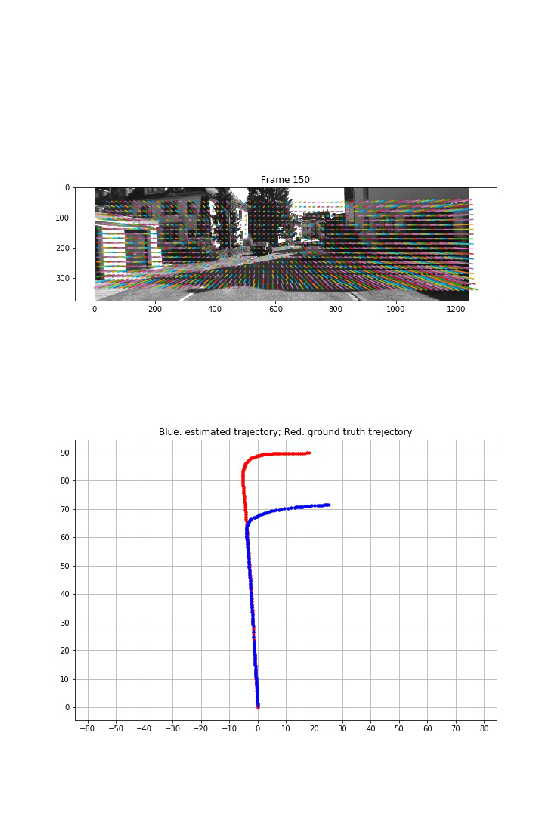

(1463, 4)
[[ 0.1306  0.0288  0.991  25.8086]
 [ 0.1295  0.9905 -0.0459 -1.9746]
 [-0.9829  0.1343  0.1257 71.7621]
 [ 0.      0.      0.      1.    ]]
Mean Error Rotation: 0.00403
Mean Error Translation: 0.89715
== [Result] Frame: 151, Matches 1463, Inliers: 99.86


<Figure size 432x288 with 0 Axes>

Saved at vis_preFeature/frame151.jpg
(1463, 4)
[[ 0.1307  0.0343  0.9908 26.3711]
 [ 0.1241  0.991  -0.0507 -2.0088]
 [-0.9836  0.1296  0.1253 71.856 ]
 [ 0.      0.      0.      1.    ]]
Mean Error Rotation: 0.00401
Mean Error Translation: 0.89288
== [Result] Frame: 152, Matches 1463, Inliers: 98.15


<Figure size 432x288 with 0 Axes>

Saved at vis_preFeature/frame152.jpg
(1463, 4)
[[ 0.131   0.037   0.9907 26.9497]
 [ 0.1235  0.9909 -0.0533 -2.0444]
 [-0.9837  0.1294  0.1252 71.9323]
 [ 0.      0.      0.      1.    ]]
Mean Error Rotation: 0.00401
Mean Error Translation: 0.88860
== [Result] Frame: 153, Matches 1463, Inliers: 97.95


<Figure size 432x288 with 0 Axes>

Saved at vis_preFeature/frame153.jpg
(1463, 4)
[[ 0.1285  0.0378  0.991  27.5162]
 [ 0.1178  0.9916 -0.0531 -2.0775]
 [-0.9847  0.1236  0.123  72.033 ]
 [ 0.      0.      0.      1.    ]]
Mean Error Rotation: 0.00402
Mean Error Translation: 0.88449
== [Result] Frame: 154, Matches 1463, Inliers: 96.38


<Figure size 432x288 with 0 Axes>

Saved at vis_preFeature/frame154.jpg
(1463, 4)
[[ 0.1305  0.0349  0.9908 28.1249]
 [ 0.119   0.9916 -0.0506 -2.1229]
 [-0.9843  0.1245  0.1253 72.0912]
 [ 0.      0.      0.      1.    ]]
Mean Error Rotation: 0.00404
Mean Error Translation: 0.88013
== [Result] Frame: 155, Matches 1463, Inliers: 95.76


<Figure size 432x288 with 0 Axes>

Saved at vis_preFeature/frame155.jpg
(1463, 4)
[[ 0.1306  0.0335  0.9909 28.7466]
 [ 0.121   0.9914 -0.0494 -2.1618]
 [-0.984   0.1264  0.1254 72.1697]
 [ 0.      0.      0.      1.    ]]
Mean Error Rotation: 0.00402
Mean Error Translation: 0.87576
== [Result] Frame: 156, Matches 1463, Inliers: 98.22


<Figure size 432x288 with 0 Axes>

Saved at vis_preFeature/frame156.jpg
(1463, 4)
[[ 0.1314  0.0324  0.9908 29.375 ]
 [ 0.1194  0.9917 -0.0483 -2.2057]
 [-0.9841  0.1247  0.1265 72.2514]
 [ 0.      0.      0.      1.    ]]
Mean Error Rotation: 0.00401
Mean Error Translation: 0.87141
== [Result] Frame: 157, Matches 1463, Inliers: 98.84


<Figure size 432x288 with 0 Axes>

Saved at vis_preFeature/frame157.jpg
(1463, 4)
[[ 0.1313  0.0328  0.9908 29.997 ]
 [ 0.1175  0.9919 -0.0484 -2.2465]
 [-0.9844  0.1227  0.1264 72.3396]
 [ 0.      0.      0.      1.    ]]
Mean Error Rotation: 0.00398
Mean Error Translation: 0.86715
== [Result] Frame: 158, Matches 1463, Inliers: 99.11


<Figure size 432x288 with 0 Axes>

Saved at vis_preFeature/frame158.jpg
(1463, 4)
[[ 0.1314  0.033   0.9908 30.6285]
 [ 0.1146  0.9922 -0.0483 -2.2912]
 [-0.9847  0.1199  0.1265 72.4266]
 [ 0.      0.      0.      1.    ]]
Mean Error Rotation: 0.00397
Mean Error Translation: 0.86285
== [Result] Frame: 159, Matches 1463, Inliers: 99.66


<Figure size 432x288 with 0 Axes>

Saved at vis_preFeature/frame159.jpg
(1463, 4)
[[ 0.1314  0.0337  0.9907 31.2753]
 [ 0.1141  0.9923 -0.0489 -2.334 ]
 [-0.9847  0.1195  0.1266 72.5011]
 [ 0.      0.      0.      1.    ]]
Mean Error Rotation: 0.00397
Mean Error Translation: 0.85850
== [Result] Frame: 160, Matches 1463, Inliers: 99.66


<Figure size 432x288 with 0 Axes>

Saved at vis_preFeature/frame160.jpg
(1463, 4)
[[ 0.1289  0.0332  0.9911 31.9619]
 [ 0.1114  0.9926 -0.0478 -2.3791]
 [-0.9854  0.1166  0.1243 72.5927]
 [ 0.      0.      0.      1.    ]]
Mean Error Rotation: 0.00395
Mean Error Translation: 0.85399
== [Result] Frame: 161, Matches 1463, Inliers: 99.38


<Figure size 432x288 with 0 Axes>

Saved at vis_preFeature/frame161.jpg
(1463, 4)
[[ 0.1258  0.0317  0.9916 32.8117]
 [ 0.1104  0.9928 -0.0457 -2.4325]
 [-0.9859  0.1152  0.1214 72.6944]
 [ 0.      0.      0.      1.    ]]
Mean Error Rotation: 0.00394
Mean Error Translation: 0.84918
== [Result] Frame: 162, Matches 1463, Inliers: 99.25


<Figure size 432x288 with 0 Axes>

Saved at vis_preFeature/frame162.jpg
(1463, 4)
[[ 0.1221  0.029   0.9921 33.8173]
 [ 0.1102  0.993  -0.0426 -2.4921]
 [-0.9864  0.1145  0.118  72.8028]
 [ 0.      0.      0.      1.    ]]
Mean Error Rotation: 0.00394
Mean Error Translation: 0.84524
== [Result] Frame: 163, Matches 1463, Inliers: 97.88


<Figure size 432x288 with 0 Axes>

Saved at vis_preFeature/frame163.jpg
(1463, 4)
[[ 0.1152  0.0273  0.993  35.0162]
 [ 0.1049  0.9937 -0.0395 -2.5696]
 [-0.9878  0.1087  0.1117 72.9614]
 [ 0.      0.      0.      1.    ]]
Mean Error Rotation: 0.00394
Mean Error Translation: 0.84258
== [Result] Frame: 164, Matches 1463, Inliers: 93.03


<Figure size 432x288 with 0 Axes>

Saved at vis_preFeature/frame164.jpg
(1463, 4)
[[ 0.1071  0.0267  0.9939 36.3061]
 [ 0.1034  0.9939 -0.0378 -2.6645]
 [-0.9889  0.1068  0.1037 73.1165]
 [ 0.      0.      0.      1.    ]]
Mean Error Rotation: 0.00393
Mean Error Translation: 0.84053
== [Result] Frame: 165, Matches 1463, Inliers: 92.28


<Figure size 432x288 with 0 Axes>

Saved at vis_preFeature/frame165.jpg
(1463, 4)
[[ 0.0989  0.027   0.9947 37.7169]
 [ 0.103   0.994  -0.0372 -2.7493]
 [-0.9898  0.1061  0.0955 73.2478]
 [ 0.      0.      0.      1.    ]]
Mean Error Rotation: 0.00392
Mean Error Translation: 0.83922
== [Result] Frame: 166, Matches 1463, Inliers: 94.46


<Figure size 432x288 with 0 Axes>

Saved at vis_preFeature/frame166.jpg
(1463, 4)
[[ 0.0882  0.0271  0.9957 39.0654]
 [ 0.1024  0.9941 -0.0361 -2.825 ]
 [-0.9908  0.1052  0.0849 73.3758]
 [ 0.      0.      0.      1.    ]]
Mean Error Rotation: 0.00391
Mean Error Translation: 0.83757
== [Result] Frame: 167, Matches 1463, Inliers: 89.41


<Figure size 432x288 with 0 Axes>

Saved at vis_preFeature/frame167.jpg
(1463, 4)
[[ 0.0786  0.0261  0.9966 40.4579]
 [ 0.1034  0.994  -0.0341 -2.8897]
 [-0.9915  0.1058  0.0754 73.4654]
 [ 0.      0.      0.      1.    ]]
Mean Error Rotation: 0.00389
Mean Error Translation: 0.83617
== [Result] Frame: 168, Matches 1463, Inliers: 89.34


<Figure size 432x288 with 0 Axes>

Saved at vis_preFeature/frame168.jpg
(1463, 4)
[[ 0.0684  0.025   0.9973 41.6332]
 [ 0.1026  0.9942 -0.032  -2.9454]
 [-0.9924  0.1045  0.0655 73.5371]
 [ 0.      0.      0.      1.    ]]
Mean Error Rotation: 0.00387
Mean Error Translation: 0.83355
== [Result] Frame: 169, Matches 1463, Inliers: 91.25


<Figure size 432x288 with 0 Axes>

Saved at vis_preFeature/frame169.jpg
(1463, 4)
[[ 0.057   0.0238  0.9981 42.7788]
 [ 0.1028  0.9943 -0.0295 -3.0017]
 [-0.9931  0.1043  0.0543 73.602 ]
 [ 0.      0.      0.      1.    ]]
Mean Error Rotation: 0.00386
Mean Error Translation: 0.83080
== [Result] Frame: 170, Matches 1463, Inliers: 96.17


<Figure size 432x288 with 0 Axes>

Saved at vis_preFeature/frame170.jpg
(1463, 4)
[[ 0.0461  0.0238  0.9987 44.1036]
 [ 0.102   0.9944 -0.0284 -3.0629]
 [-0.9937  0.1032  0.0434 73.6561]
 [ 0.      0.      0.      1.    ]]
Mean Error Rotation: 0.00385
Mean Error Translation: 0.82914
== [Result] Frame: 171, Matches 1463, Inliers: 95.22


<Figure size 432x288 with 0 Axes>

Saved at vis_preFeature/frame171.jpg
(1463, 4)
[[ 0.0353  0.0239  0.9991 45.5577]
 [ 0.1016  0.9944 -0.0274 -3.1336]
 [-0.9942  0.1025  0.0327 73.6985]
 [ 0.      0.      0.      1.    ]]
Mean Error Rotation: 0.00384
Mean Error Translation: 0.82828
== [Result] Frame: 172, Matches 1463, Inliers: 92.82


<Figure size 432x288 with 0 Axes>

Saved at vis_preFeature/frame172.jpg
(1463, 4)
[[ 0.0248  0.0248  0.9994 47.1096]
 [ 0.1017  0.9944 -0.0272 -3.2018]
 [-0.9945  0.1023  0.0222 73.7302]
 [ 0.      0.      0.      1.    ]]
Mean Error Rotation: 0.00382
Mean Error Translation: 0.82801
== [Result] Frame: 173, Matches 1463, Inliers: 86.06


<Figure size 432x288 with 0 Axes>

Saved at vis_preFeature/frame173.jpg
(1463, 4)
[[ 0.0139  0.0261  0.9996 48.8269]
 [ 0.1015  0.9945 -0.0274 -3.2698]
 [-0.9947  0.1018  0.0112 73.7635]
 [ 0.      0.      0.      1.    ]]
Mean Error Rotation: 0.00381
Mean Error Translation: 0.82874
== [Result] Frame: 174, Matches 1463, Inliers: 82.09


<Figure size 432x288 with 0 Axes>

Saved at vis_preFeature/frame174.jpg
(1463, 4)
[[ 0.0037  0.0267  0.9996 50.4723]
 [ 0.1016  0.9945 -0.027  -3.3437]
 [-0.9948  0.1017  0.001  73.7776]
 [ 0.      0.      0.      1.    ]]
Mean Error Rotation: 0.00379
Mean Error Translation: 0.82910
== [Result] Frame: 175, Matches 1463, Inliers: 82.23


<Figure size 432x288 with 0 Axes>

Saved at vis_preFeature/frame175.jpg
(1463, 4)
[[-0.0069  0.0272  0.9996 51.7853]
 [ 0.1009  0.9945 -0.0264 -3.3961]
 [-0.9949  0.1007 -0.0096 73.7809]
 [ 0.      0.      0.      1.    ]]
Mean Error Rotation: 0.00379
Mean Error Translation: 0.82761
== [Result] Frame: 176, Matches 1463, Inliers: 87.22


<Figure size 432x288 with 0 Axes>

Saved at vis_preFeature/frame176.jpg
(1463, 4)
[[-0.0161  0.0274  0.9995 52.3036]
 [ 0.1029  0.9944 -0.0256 -3.4175]
 [-0.9946  0.1025 -0.0188 73.7685]
 [ 0.      0.      0.      1.    ]]
Mean Error Rotation: 0.00377
Mean Error Translation: 0.82426
== [Result] Frame: 177, Matches 1463, Inliers: 93.03


<Figure size 432x288 with 0 Axes>

Saved at vis_preFeature/frame177.jpg
(1463, 4)
[[-0.0242  0.0267  0.9994 52.8399]
 [ 0.1058  0.9941 -0.024  -3.4394]
 [-0.9941  0.1052 -0.0269 73.7464]
 [ 0.      0.      0.      1.    ]]
Mean Error Rotation: 0.00377
Mean Error Translation: 0.82080
== [Result] Frame: 178, Matches 1463, Inliers: 98.50


<Figure size 432x288 with 0 Axes>

Saved at vis_preFeature/frame178.jpg
(1463, 4)
[[-0.0318  0.0257  0.9992 53.3741]
 [ 0.1078  0.9939 -0.0222 -3.457 ]
 [-0.9937  0.107  -0.0344 73.7286]
 [ 0.      0.      0.      1.    ]]
Mean Error Rotation: 0.00375
Mean Error Translation: 0.81736
== [Result] Frame: 179, Matches 1463, Inliers: 98.56


<Figure size 432x288 with 0 Axes>

Saved at vis_preFeature/frame179.jpg
(1463, 4)
[[-0.0369  0.0238  0.999  53.8855]
 [ 0.1106  0.9937 -0.0196 -3.4762]
 [-0.9932  0.1098 -0.0393 73.7048]
 [ 0.      0.      0.      1.    ]]
Mean Error Rotation: 0.00373
Mean Error Translation: 0.81403
== [Result] Frame: 180, Matches 1463, Inliers: 98.84


<Figure size 432x288 with 0 Axes>

Saved at vis_preFeature/frame180.jpg
(1463, 4)
[[-0.041   0.022   0.9989 54.402 ]
 [ 0.1122  0.9935 -0.0172 -3.4946]
 [-0.9928  0.1114 -0.0432 73.6819]
 [ 0.      0.      0.      1.    ]]
Mean Error Rotation: 0.00372
Mean Error Translation: 0.81068
== [Result] Frame: 181, Matches 1463, Inliers: 99.04


<Figure size 432x288 with 0 Axes>

Saved at vis_preFeature/frame181.jpg
(1463, 4)
[[-0.0448  0.0208  0.9988 54.9299]
 [ 0.112   0.9936 -0.0156 -3.5107]
 [-0.9927  0.1112 -0.0469 73.6677]
 [ 0.      0.      0.      1.    ]]
Mean Error Rotation: 0.00372
Mean Error Translation: 0.80726
== [Result] Frame: 182, Matches 1463, Inliers: 99.18


<Figure size 432x288 with 0 Axes>

Saved at vis_preFeature/frame182.jpg
(1463, 4)
[[-0.0484  0.0203  0.9986 55.4417]
 [ 0.1096  0.9939 -0.0149 -3.5249]
 [-0.9928  0.1087 -0.0504 73.6611]
 [ 0.      0.      0.      1.    ]]
Mean Error Rotation: 0.00373
Mean Error Translation: 0.80390
== [Result] Frame: 183, Matches 1463, Inliers: 99.59


<Figure size 432x288 with 0 Axes>

Saved at vis_preFeature/frame183.jpg
(1463, 4)
[[-0.0459  0.021   0.9987 55.9327]
 [ 0.1147  0.9933 -0.0156 -3.5416]
 [-0.9923  0.1139 -0.048  73.6027]
 [ 0.      0.      0.      1.    ]]
Mean Error Rotation: 0.00375
Mean Error Translation: 0.80053
== [Result] Frame: 184, Matches 1463, Inliers: 98.43


<Figure size 432x288 with 0 Axes>

Saved at vis_preFeature/frame184.jpg
(1463, 4)
[[-0.0448  0.0221  0.9988 56.4126]
 [ 0.1167  0.993  -0.0168 -3.5557]
 [-0.9922  0.1158 -0.0471 73.5755]
 [ 0.      0.      0.      1.    ]]
Mean Error Rotation: 0.00374
Mean Error Translation: 0.79720
== [Result] Frame: 185, Matches 1463, Inliers: 99.93


<Figure size 432x288 with 0 Axes>

Saved at vis_preFeature/frame185.jpg
(1463, 4)
[[-0.0421  0.0238  0.9988 56.878 ]
 [ 0.1181  0.9928 -0.0187 -3.5712]
 [-0.9921  0.1172 -0.0446 73.556 ]
 [ 0.      0.      0.      1.    ]]
Mean Error Rotation: 0.00372
Mean Error Translation: 0.79390
== [Result] Frame: 186, Matches 1463, Inliers: 100.00


<Figure size 432x288 with 0 Axes>

Saved at vis_preFeature/frame186.jpg
(1463, 4)
[[-0.0369  0.0243  0.999  57.3314]
 [ 0.118   0.9928 -0.0198 -3.5869]
 [-0.9923  0.1171 -0.0395 73.5394]
 [ 0.      0.      0.      1.    ]]


In [ ]:
import runMatch
dataset_path = '/datasets/cse152-252-sp20-public/dataset_SfM'
feature_dir = 'Flow'
errors_df=runMatch.runSFM(dataset_path, feature_dir )

1. Report the final rotation and translation error. **(2 points)**

``report two error metrics over all frames here``

In [3]:
'''Not to be reported'''
# print("Rotation and Transition Error metric for all frames \n")
# errors_df.index = np.arange(1, len(errors_df) + 1)
# errors_df.index.name = "Frame Number"
# with pd.option_context('display.max_rows', None, 'display.max_columns', None):
#     print(errors_df)

'Not to be reported'

Next, answer the following questions:

2. Does SPyNet yield higher accuracy than the original $\mathtt{libviso2}$? Why or why not? If not, what steps can you take to improve? **(5 points)**

``answer here``

3. Explain how SPyNet achieves accurate flow with significantly lower computational cost. **(3 points)**

``answer here``

Basic goal: learn a CNN Gk to predict residual flow at each level

* Each level solves a simple problem, so each level Gk can have simple architecture ..........

## Question 5: Using Sfm-learner for SFM
Now we will use deep neural networks for SFM. Please follow the open-source Sfmlearner repository (https://github.com/ClementPinard/SfmLearner-Pytorch) and the paper (https://people.eecs.berkeley.edu/~tinghuiz/projects/SfMLearner/cvpr17_sfm_final.pdf) to answer the following questions.

1. Follow the steps to add sfm-learner as a submodule:
`git submodule add https://github.com/ClementPinard/SfmLearner-Pytorch.git`.
1. you might have to do `git submodule update --init --recursive` for older git version or on other systems which already have previous commits locally.
1. For cloning the repository use `git clone --recursive <project url>` to download submodule also

1. Describe how photometric loss is implemented in Sfmlearner? Please refer to the paper and the code. **(5 points)**

``answer here``
The Photometric loss is based on warping nearby views to the target using the computed depth and pose.<br>
The depth and explainability mask predictions from single-view depth network and pose/explainability network are used to compute the photometric loss. The source image is warped and L1 loss is computed with respected to target image. The loss is computed at different scale(factor of 2) of image and is accumulated over each scales. <br>
Mathematically loss can be written as: <br>
Photometric Loss $(L_{vs}) = \displaystyle\sum_{<I_1, ... ,I_N> \in S} \sum_p \hat{E}_s(p) \mid I_t(p) - \hat{I_s}(p)  \mid$ <br>
where, $\hat{E}_s(p)$ is output(prediction) of explainability prediction network and is per-pixel($p$) soft mask for each target-source pair.

Further, to encourage non-trivial(non-zero) prediction of $\hat{E}_s$ we introduce a regularization loss called explainability loss.

2. Train the model and show the training curve, validation curve, and visualization of predicted depth and warped images? Which loss is decreasing and which is increasing? Why? **(10 points)**

 Visualize the specific images: `val_Depth_Output_Normalized/0`, `val_Warped_Outputs/0` from tensorboard.
 
 Training data: 
`/datasets/cse152-252-sp20-public/sfmlearner_h128w416`.

#### Install the environment
`pip install -r requirements.txt`
- fix scipy version problem: 

`pip install scipy==1.1.0 --user`

#### Training script
`cd SfmLearner-Pytorch`

`python3 train.py /datasets/cse152-252-sp20-public/sfmlearner_h128w416 -b4 -m0.2 -s0.1 --epoch-size 3000 --sequence-length 3 --log-output`




``answer here``

3. When training the model, we use 3 consecutive frames. Now, you will use the photometric consistency between the 1st and the 3rd frame. To be more specific, you can get the pose $T_{1,3} = T_{2,3} @ T_{1,2}$, where $T_{1,2}, T_{2,3}$ have already been computed in the original code. Add the constraint to the total loss and report the results in the same manner as in part 2 above. **(10 points)**

``answer here``

4. Now, you will evaluate your models from parts (2), (3) on the KITTI odometry dataset. What are the error metrics used in Sfm-learner? Please report the `ATE` and `RE` for sequence `09` and `10`. **(5 points)**

  Data: `/datasets/cse152-252-sp20-public/kitti`.

#### Evaluation script
`python3 test_pose.py /path/to/posenet --dataset-dir /datasets/cse152-252-sp20-public/kitti --sequences 09`

``answer here``

### Notes:
- scp data to local machines:

`scp -r <USERNAME>@dsmlp-login.ucsd.edu:/datasets/cse152-252-sp20-public/sfmlearner_h128w416.zip`

`scp -r <USERNAME>@dsmlp-login.ucsd.edu:/datasets/cse152-252-sp20-public/kitti.zip`
...
- tensorboard: open jupyter notebook from the link after `launch-scipy-ml-gpu.sh`. Click new `Tensorboard ..`

# References
1. Daniel DeTone, Tomasz Malisiewicz, and Andrew Rabinovich. Superpoint: Self-supervised interest point detection and description. In Proceedings of the IEEE Conference on Computer Vision and Pattern Recognition Workshops, pages 224–236, 2018.
2. Andreas Geiger, Philip Lenz, and Raquel Urtasun. Are we ready for autonomous driving? the kitti vision benchmark suite. In Conference on Computer Vision and Pattern Recognition (CVPR), 2012.
3. Andreas Geiger, Julius Ziegler, and Christoph Stiller. Stereoscan: Dense 3d reconstruction in real-time. In Intelligent Vehicles Symposium (IV), 2011.
4. David G Lowe. Distinctive image features from scale-invariant keypoints. IJCV, 60(2):91–110, 2004.
5. Anurag Ranjan and Michael J Black. Optical flow estimation using a spatial pyramid network. In
Proceedings of the IEEE Conference on Computer Vision and Pattern Recognition, pages 4161–4170, 2017.
6. A. Vedaldi and B. Fulkerson. VLFeat: An open and portable library of computer vision algorithms. http://www.vlfeat.org/, 2008.
7. Lucas, Bruce D., and Takeo Kanade. "An iterative image registration technique with an application to stereo vision." (1981): 674.
8. B. Kitt, A. Geiger, and H. Lategahn, “Visual odometry based on stereo image sequences with RANSAC-based outlier rejection scheme,” in 2010 IEEE Intelligent Vehicles Symposium, La Jolla, CA, USA, Jun. 2010, pp. 486–492, doi: 10.1109/IVS.2010.5548123.
9. A. Geiger, J. Ziegler, and C. Stiller, “StereoScan: Dense 3d reconstruction in real-time,” in 2011 IEEE Intelligent Vehicles Symposium (IV), Baden-Baden, Germany, Jun. 2011, pp. 963–968, doi: 10.1109/IVS.2011.5940405.